# LASSO regression to associate TCR clonality change using pre-treatment samples as input only

Script related to figure 6f

Aim:
- Perform LASSO regression to evaluate which hallmark transcriptional programs and consensusTME estimates associates with TCR clonal expansion

- Response variable: Log2(Pre/Post-NACT TCR-clonality)

- Explanatory variables: Pre-NACT Hallmark and ConsensusTME Normalized Enrichment Scores

In [1]:
rm(list=ls())

In [2]:
set.seed(1)

## Install packages

In [3]:
#install.packages("plotmo")

## Load packages

In [4]:
library(glmnet)
library(plotmo)

Loading required package: Matrix
Loading required package: foreach
Loaded glmnet 2.0-16

Warning message:
“package ‘plotmo’ was built under R version 3.5.2”Loading required package: Formula
Loading required package: plotrix
Loading required package: TeachingDemos


In [5]:
setwd("~/Documents/PhD/Software/Scripts/OVCT/1.REBUTTAL/0.Figures/6/0.Scripts/")

## Load hallmark + TCRseq prod clon data

In [6]:
hallmark_nes <- read.table(
    "../1.Data/Hallmark_NES_TCR_prodclon_diff.txt",
    sep = "\t",
    header = T,
    row.names = "X"
)

hallmark_nes

HALLMARK_TNFA_SIGNALING_VIA_NFKB HALLMARK_HYPOXIA
A01 0.09269600                       0.1860102       
A03 0.22155984                       0.2148187       
A05 0.09978517                       0.1927703       
A07 0.10021217                       0.1652828       
A11 0.12762997                       0.2081528       
B02 0.10401762                       0.2102374       
B04 0.26892185                       0.2673331       
B06 0.16284166                       0.1991851       
    HALLMARK_CHOLESTEROL_HOMEOSTASIS HALLMARK_MITOTIC_SPINDLE
A01 0.2552083                        0.3052184               
A03 0.2850831                        0.2938264               
A05 0.3212674                        0.2786730               
A07 0.2929426                        0.2982894               
A11 0.3080618                        0.3724130               
B02 0.3289171                        0.3401526               
B04 0.3036478                        0.3162014               
B06 0.3497773                        0.2698003               
    HALLMARK_WNT_BETA_CATENIN_SIGNALING HALLMARK_TGF_BETA_SIGNALING
A01 0.2187753                           0.3193089                  
A03 0.2122143                           0.3235186                  
A05 0.2525414                           0.2748441                  
A07 0.2429414                           0.2681703                  
A11 0.2510767                           0.2734692                  
B02 0.2717549                           0.3247727                  
B04 0.2100100                           0.3632937                  
B06 0.2006637                           0.2894679                  
    HALLMARK_IL6_JAK_STAT3_SIGNALING HALLMARK_DNA_REPAIR
A01 0.06320428                       0.2831491          
A03 0.21971637                       0.2793292          
A05 0.08024351                       0.2865531          
A07 0.06758169                       0.2899777          
A11 0.14171051                       0.3313506          
B02 0.14285215                       0.3537992          
B04 0.22379374                       0.3003250          
B06 0.13634125                       0.2733557          
    HALLMARK_G2M_CHECKPOINT HALLMARK_APOPTOSIS ⋯ HALLMARK_BILE_ACID_METABOLISM
A01 0.3661022               0.2931641          ⋯ 0.017702715                  
A03 0.2720179               0.3687604          ⋯ 0.068881179                  
A05 0.3447186               0.3016157          ⋯ 0.046353081                  
A07 0.3022442               0.3193088          ⋯ 0.077654341                  
A11 0.4210878               0.3474470          ⋯ 0.004933478                  
B02 0.4132900               0.3012210          ⋯ 0.033024743                  
B04 0.3319118               0.3947189          ⋯ 0.047064942                  
B06 0.3464022               0.3057666          ⋯ 0.054901630                  
    HALLMARK_PEROXISOME HALLMARK_ALLOGRAFT_REJECTION HALLMARK_SPERMATOGENESIS
A01 0.1570135           0.1011018                     0.059222633            
A03 0.1593034           0.2409440                    -0.013732903            
A05 0.2009610           0.1134920                     0.074904154            
A07 0.2315384           0.1497834                     0.076340931            
A11 0.2134636           0.1862752                     0.073283895            
B02 0.2012456           0.1638317                     0.039419387            
B04 0.2277854           0.2890507                     0.009257675            
B06 0.1801053           0.1530384                     0.096167456            
    HALLMARK_KRAS_SIGNALING_UP HALLMARK_KRAS_SIGNALING_DN
A01 0.1688697                  -0.1113663                
A03 0.2622651                  -0.1220071                
A05 0.1259934                  -0.1062689                
A07 0.1542246                  -0.1025494                
A11 0.1789783                  -0.1629938                
B02 0.1945194                  -0.1609898                
B04 0.2755783   

### Remove "Hallmark_" label to get shorter names

In [7]:
names(hallmark_nes) <- gsub("HALLMARK_", "", names(hallmark_nes), fixed = TRUE)
hallmark_nes

TNFA_SIGNALING_VIA_NFKB HYPOXIA   CHOLESTEROL_HOMEOSTASIS MITOTIC_SPINDLE
A01 0.09269600              0.1860102 0.2552083               0.3052184      
A03 0.22155984              0.2148187 0.2850831               0.2938264      
A05 0.09978517              0.1927703 0.3212674               0.2786730      
A07 0.10021217              0.1652828 0.2929426               0.2982894      
A11 0.12762997              0.2081528 0.3080618               0.3724130      
B02 0.10401762              0.2102374 0.3289171               0.3401526      
B04 0.26892185              0.2673331 0.3036478               0.3162014      
B06 0.16284166              0.1991851 0.3497773               0.2698003      
    WNT_BETA_CATENIN_SIGNALING TGF_BETA_SIGNALING IL6_JAK_STAT3_SIGNALING
A01 0.2187753                  0.3193089          0.06320428             
A03 0.2122143                  0.3235186          0.21971637             
A05 0.2525414                  0.2748441          0.08024351             
A07 0.2429414                  0.2681703          0.06758169             
A11 0.2510767                  0.2734692          0.14171051             
B02 0.2717549                  0.3247727          0.14285215             
B04 0.2100100                  0.3632937          0.22379374             
B06 0.2006637                  0.2894679          0.13634125             
    DNA_REPAIR G2M_CHECKPOINT APOPTOSIS ⋯ BILE_ACID_METABOLISM PEROXISOME
A01 0.2831491  0.3661022      0.2931641 ⋯ 0.017702715          0.1570135 
A03 0.2793292  0.2720179      0.3687604 ⋯ 0.068881179          0.1593034 
A05 0.2865531  0.3447186      0.3016157 ⋯ 0.046353081          0.2009610 
A07 0.2899777  0.3022442      0.3193088 ⋯ 0.077654341          0.2315384 
A11 0.3313506  0.4210878      0.3474470 ⋯ 0.004933478          0.2134636 
B02 0.3537992  0.4132900      0.3012210 ⋯ 0.033024743          0.2012456 
B04 0.3003250  0.3319118      0.3947189 ⋯ 0.047064942          0.2277854 
B06 0.2733557  0.3464022      0.3057666 ⋯ 0.054901630          0.1801053 
    ALLOGRAFT_REJECTION SPERMATOGENESIS KRAS_SIGNALING_UP KRAS_SIGNALING_DN
A01 0.1011018            0.059222633    0.1688697         -0.1113663       
A03 0.2409440           -0.013732903    0.2622651         -0.1220071       
A05 0.1134920            0.074904154    0.1259934         -0.1062689       
A07 0.1497834            0.076340931    0.1542246         -0.1025494       
A11 0.1862752            0.073283895    0.1789783         -0.1629938       
B02 0.1638317            0.039419387    0.1945194         -0.1609898       
B04 0.2890507            0.009257675    0.2755783         -0.1275930       
B06 0.1530384            0.096167456    0.1517699         -0.1451783       
    PANCREAS_BETA_CELLS StromalSignature ImmuneSignature TCR_post_pre
A01 -0.1464566          0.06830078       0.07469119       0.82121647 
A03 -0.2295195          0.26965127       0.34573018       0.30162732 
A05 -0.1370080          0.02342274       0.06911363       0.68871043 
A07 -0.2398087          0.15540669       0.13577920      -0.05367598 
A11 -0.2748383          0.14377413       0.17850991       0.13568710 
B02 -0.2601894          0.18772533       0.16328647       1.13781465 
B04 -0.1769538          0.26569065       0.36304628       0.14493776 
B06 -0.1921719          0.12224239       0.09072112       0.57524735

## Load ConsensusTME + TCRseq prod clon data

In [8]:
consensus_nes <- read.table(
    "../1.Data/Consensus_NES_TCR_prodclon_diff.txt",
    sep = "\t",
    header = T,
    row.names = "X"
)

consensus_nes

B_cells   Cytotoxic_cells Dendritic_cells Endothelial Eosinophils
A01 0.2544767  0.160123909    0.23412023       0.14187053 -0.10418995
A03 0.3284338  0.250782530    0.35828990       0.35977859  0.11827621
A05 0.1584463  0.149996721    0.09665491      -0.03893381 -0.13614199
A07 0.1536159  0.183015171    0.18651974      -0.02317958  0.02233556
A11 0.1980917  0.008473049    0.18175940       0.18569091 -0.08668622
B02 0.2402263  0.041651386    0.19604279       0.13219214 -0.03672601
B04 0.2839035  0.297392517    0.41154229       0.32445657  0.23703105
B06 0.1358404 -0.060471010    0.13645580      -0.01334995 -0.06623356
    Fibroblasts Macrophages Macrophages_M1 Macrophages_M2 Mast_cells  Monocytes
A01  0.09241945 0.2670112   0.1720899      0.1814478       0.02192616 0.2304878
A03  0.30425047 0.4091265   0.2950658      0.3210669       0.04103930 0.3858617
A05  0.03414850 0.2307931   0.1273806      0.2043502      -0.15383368 0.2006747
A07  0.27570475 0.3202105   0.1366862      0.2791626       0.16957993 0.2584613
A11  0.27665652 0.2290297   0.2699370      0.1933054      -0.16356791 0.1734075
B02  0.26149548 0.3296904   0.2648137      0.2625680       0.11898768 0.2465675
B04  0.16866140 0.4024553   0.3650535      0.4139615       0.11777950 0.3647248
B06 -0.03450019 0.3311684   0.2358284      0.1790985      -0.01447437 0.2186006
    NK_cells    Neutrophils Plasma_cells T_cells_CD4 T_cells_CD8
A01 -0.02041523 0.1091831   0.3268816    -0.15126030 -0.12458821
A03  0.02020867 0.3013136   0.4849676     0.15489972  0.09899607
A05 -0.09731896 0.2647767   0.2534280    -0.21209991 -0.16972010
A07 -0.07103514 0.3356848   0.3347700    -0.14626064 -0.16726861
A11 -0.14887341 0.2404555   0.4557533    -0.17500666 -0.11661655
B02 -0.11443602 0.2835240   0.3383852    -0.16099866 -0.10924458
B04  0.09147193 0.3717044   0.5847199     0.09239342  0.12828607
B06 -0.17431637 0.1910897   0.1703691    -0.20636331 -0.20507770
    T_cells_gamma_delta T_regulatory_cells TCR_post_pre
A01 -0.12105553         -0.1713167          0.82121647 
A03  0.02099488          0.1249444          0.30162732 
A05 -0.18042408         -0.2879235          0.68871043 
A07 -0.14399889         -0.3454618         -0.05367598 
A11 -0.11139796         -0.2121492          0.13568710 
B02 -0.10747554         -0.2983638          1.13781465 
B04  0.07697151          0.1893823          0.14493776 
B06 -0.20014783         -0.3527968          0.57524735

## Select explanatory and response variables

In [147]:
# EXPLANATORY: Hallmarks NES
h <- as.matrix(subset(hallmark_nes, select = -c(TCR_post_pre)))

# EXPLANATORY: Consensus cells
c <- as.matrix(subset(consensus_nes, select = -c(TCR_post_pre)))

# RESPONSE: Log2 tcr change pre/post-NACT
t <- as.matrix(subset(hallmark_nes, select =  c(TCR_post_pre)))

In [10]:
# COMMENT
# hc matrix variables should have unit variance and mean 0

## Combine Hallmark and Consensus features

In [11]:
hc <- cbind(h,c)

In [12]:
dim(h)

[1]  8 52

In [13]:
dim(c)

[1]  8 18

In [14]:
colors = c(rep("gold",52),rep("darkgreen",18))

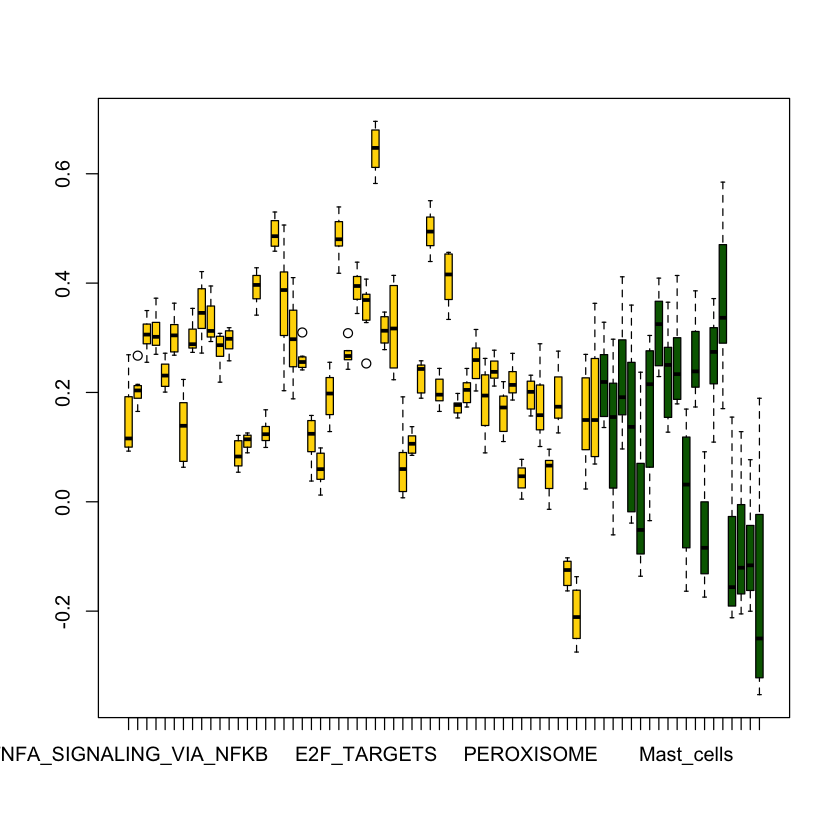

In [15]:
# hallmarks -> gold, consensus cells -> green
boxplot(hc, col=colors)

## Size

In [16]:
n = nrow(hc)
p = ncol(hc)
n
p

[1] 8

[1] 70

In [17]:
# COMMENT
# - n << p

## Check response TCRseq clonal production log2(post/pre) distribution

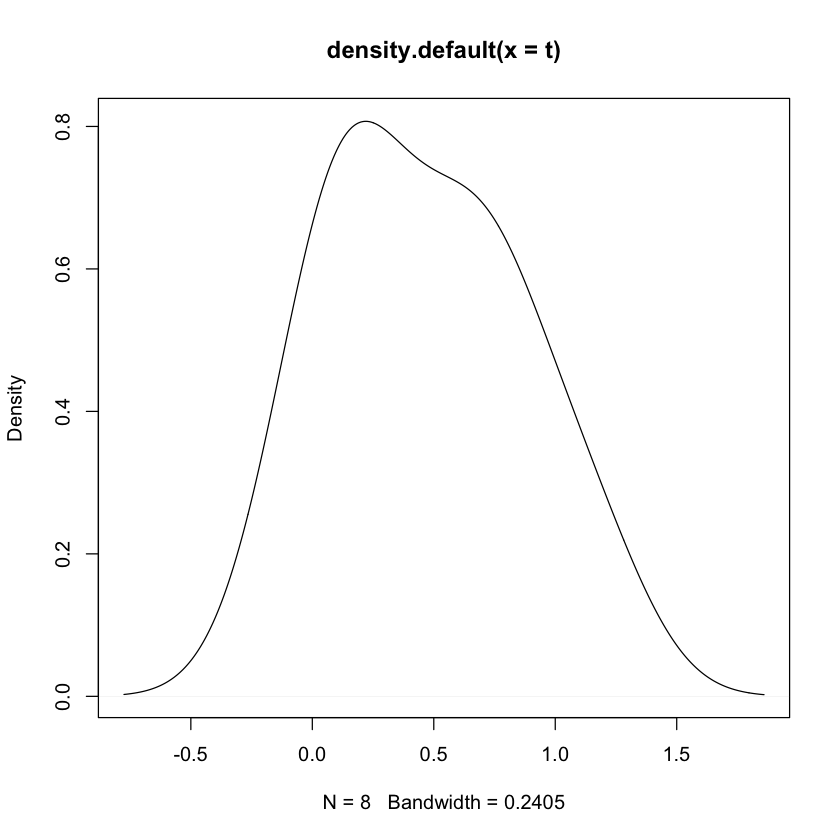

In [18]:
plot(density(t)) # the data is log2(t1/t0)

In [19]:
shapiro.test(t)


	Shapiro-Wilk normality test

data:  t
W = 0.9573, p-value = 0.784


In [20]:
# COMMENT:
# - rather a small sample size for this

### Check hc matrix before standardisation

#### Check relationship between hc variables by performing pca on transposed hc matrix

In [21]:
pr.var = princomp(t(hc),cor=TRUE)

In [22]:
head(cor(hc))

TNFA_SIGNALING_VIA_NFKB HYPOXIA   
TNFA_SIGNALING_VIA_NFKB     1.00000000              0.8378047
HYPOXIA                     0.83780471              1.0000000
CHOLESTEROL_HOMEOSTASIS     0.03534213              0.1362285
MITOTIC_SPINDLE            -0.08454371              0.2530826
WNT_BETA_CATENIN_SIGNALING -0.64114227             -0.2945605
TGF_BETA_SIGNALING          0.67357482              0.7888147
                           CHOLESTEROL_HOMEOSTASIS MITOTIC_SPINDLE
TNFA_SIGNALING_VIA_NFKB     0.03534213             -0.08454371    
HYPOXIA                     0.13622847              0.25308255    
CHOLESTEROL_HOMEOSTASIS     1.00000000             -0.10320814    
MITOTIC_SPINDLE            -0.10320814              1.00000000    
WNT_BETA_CATENIN_SIGNALING  0.17248467              0.52491323    
TGF_BETA_SIGNALING         -0.22464499              0.07901500    
                           WNT_BETA_CATENIN_SIGNALING TGF_BETA_SIGNALING
TNFA_SIGNALING_VIA_NFKB    -0.6411423                  0.6735748        
HYPOXIA                    -0.2945605                  0.7888147        
CHOLESTEROL_HOMEOSTASIS     0.1724847                 -0.2246450        
MITOTIC_SPINDLE             0.5249132                  0.0790150        
WNT_BETA_CATENIN_SIGNALING  1.0000000                 -0.3676381        
TGF_BETA_SIGNALING         -0.3676381                  1.0000000        
                           IL6_JAK_STAT3_SIGNALING DNA_REPAIR  G2M_CHECKPOINT
TNFA_SIGNALING_VIA_NFKB     0.9068651              -0.21732856 -0.4520212    
HYPOXIA                     0.8512841               0.21126097  0.0322958    
CHOLESTEROL_HOMEOSTASIS     0.1533010               0.23471816  0.2756434    
MITOTIC_SPINDLE             0.1775419               0.84635237  0.6956988    
WNT_BETA_CATENIN_SIGNALING -0.3691729               0.75937515  0.5630129    
TGF_BETA_SIGNALING          0.6613366               0.09949435 -0.1080564    
                           APOPTOSIS  ⋯ Macrophages_M2 Mast_cells Monocytes 
TNFA_SIGNALING_VIA_NFKB     0.8844528 ⋯  0.76839931     0.2344276  0.8053240
HYPOXIA                     0.7699170 ⋯  0.69473880     0.1013731  0.5706724
CHOLESTEROL_HOMEOSTASIS    -0.1423744 ⋯ -0.14248156    -0.1993995 -0.2956890
MITOTIC_SPINDLE             0.2470769 ⋯  0.05149323    -0.1085478 -0.1967845
WNT_BETA_CATENIN_SIGNALING -0.3706946 ⋯ -0.21104402    -0.1363894 -0.4820202
TGF_BETA_SIGNALING          0.5129042 ⋯  0.68949263     0.4871823  0.7269681
                           NK_cells    Neutrophils Plasma_cells T_cells_CD4
TNFA_SIGNALING_VIA_NFKB     0.65044094 0.5071427    0.6651793    0.8464505 
HYPOXIA                     0.56446854 0.4425213    0.7035661    0.6393417 
CHOLESTEROL_HOMEOSTASIS    -0.60090113 0.1844534   -0.4195939   -0.3662213 
MITOTIC_SPINDLE            -0.08872417 0.1016759    0.5172430   -0.0265028 
WNT_BETA_CATENIN_SIGNALING -0.41343602 0.1597418   -0.1083523   -0.4743190 
TGF_BETA_SIGNALING          0.75743661 0.2233162    0.5964753    0.6973098 
                           T_cells_CD8 T_cells_gamma_delta T_regulatory_cells
TNFA_SIGNALING_VIA_NFKB     0.8541645   0.8247282           0.85441187       
HYPOXIA                     0.7905521   0.7937679           0.77598905       
CHOLESTEROL_HOMEOSTASIS    -0.3304863  -0.3636299          -0.40821690       
MITOTIC_SPINDLE             0.1452367   0.2386068           0.08203114       
WNT_BETA_CATENIN_SIGNALING -0.3691585  -0.3232734          -0.48567759       
TGF_BETA_SIGNALING          0.7887867   0.8018811           0.76874936

In [23]:
summary(pr.var)

Importance of components:
                          Comp.1     Comp.2     Comp.3     Comp.4      Comp.5
Standard deviation     2.6756387 0.72336486 0.29891862 0.26737510 0.245068467
Proportion of Variance 0.8948803 0.06540709 0.01116904 0.00893618 0.007507319
Cumulative Proportion  0.8948803 0.96028738 0.97145642 0.98039260 0.987899917
                            Comp.6      Comp.7      Comp.8
Standard deviation     0.227517840 0.186850388 0.100614248
Proportion of Variance 0.006470546 0.004364133 0.001265403
Cumulative Proportion  0.994370463 0.998734597 1.000000000

In [24]:
pr.var[[2]]


Loadings:
    Comp.1 Comp.2 Comp.3 Comp.4 Comp.5 Comp.6 Comp.7 Comp.8
A01  0.361  0.163  0.367  0.224  0.793  0.115              
A03  0.330 -0.617         0.295         0.208 -0.613       
A05  0.358  0.293  0.287 -0.365        -0.516 -0.442 -0.319
A07  0.358  0.204 -0.771         0.168 -0.180 -0.114  0.394
A11  0.365         0.261  0.486 -0.461 -0.336  0.289  0.391
B02  0.368  0.116 -0.309  0.283 -0.100  0.143  0.325 -0.735
B04  0.331 -0.596        -0.543        -0.126  0.466       
B06  0.356  0.308  0.155 -0.335 -0.324  0.704         0.200

               Comp.1 Comp.2 Comp.3 Comp.4 Comp.5 Comp.6 Comp.7 Comp.8
SS loadings     1.000  1.000  1.000  1.000  1.000  1.000  1.000  1.000
Proportion Var  0.125  0.125  0.125  0.125  0.125  0.125  0.125  0.125
Cumulative Var  0.125  0.250  0.375  0.500  0.625  0.750  0.875  1.000

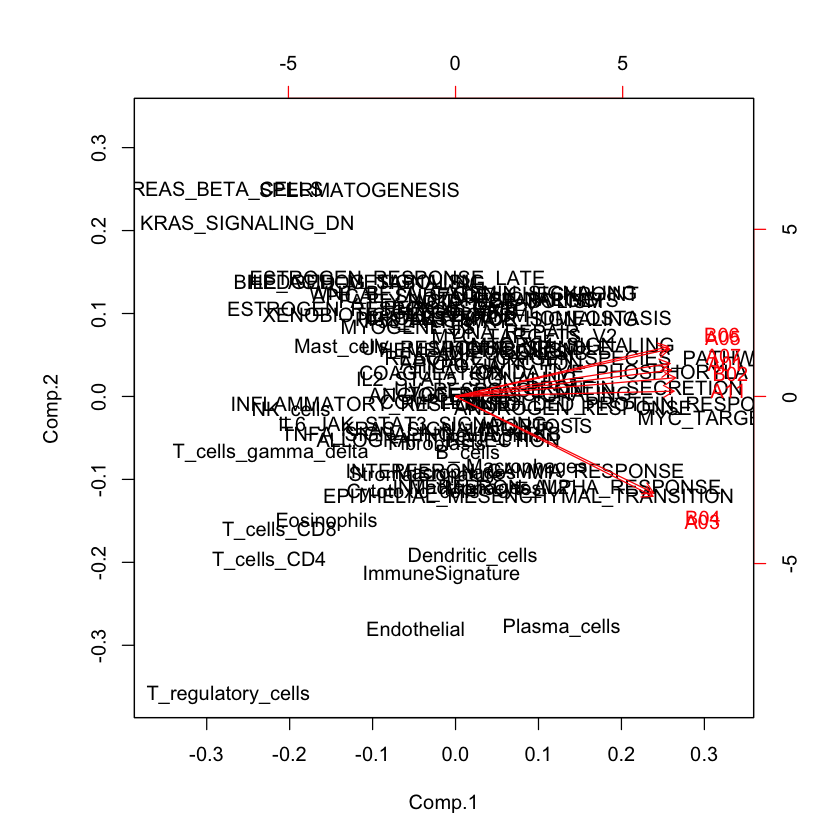

In [25]:
biplot(pr.var)

In [26]:
# COMMENT
# - 90% of the var = mean...

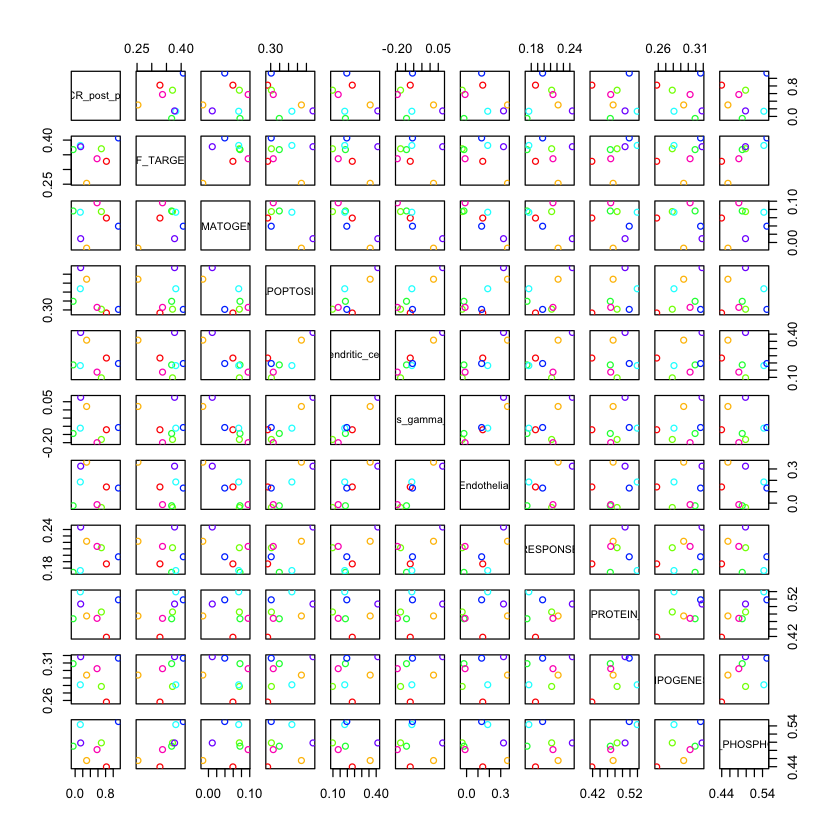

In [27]:
pairs(cbind(t,hc[,order(runif(p))[1:10]]),col=rainbow(n))


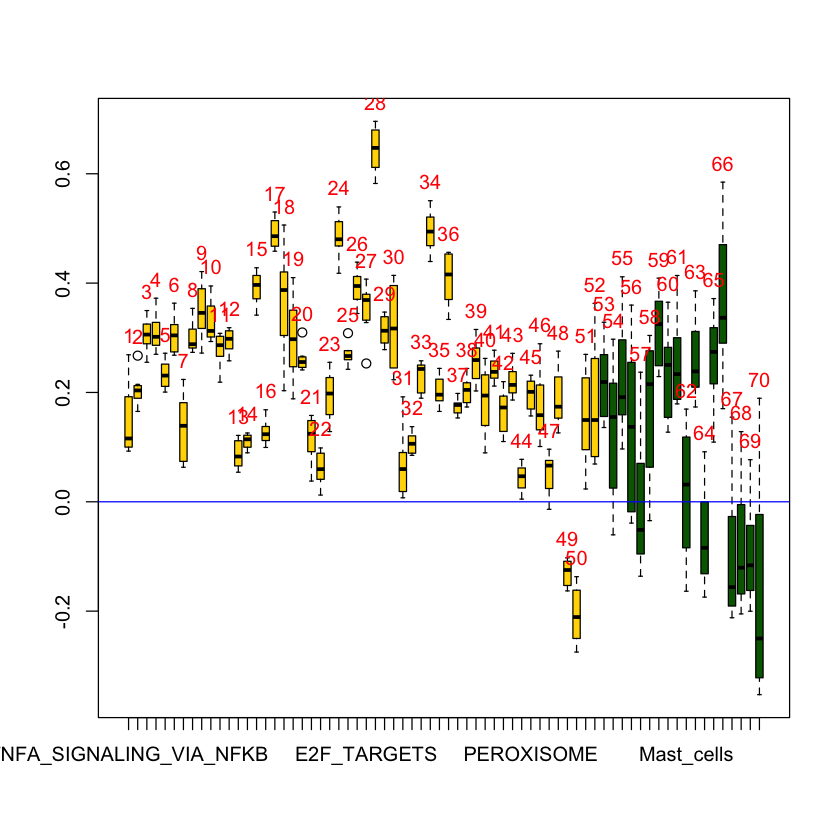

In [28]:
boxplot(hc,col=colors)
abline(h=0,col="blue")
text(1:p,apply(hc,2,max),1:p,col="red",pos=3)

In [29]:
# CONCLUSION:
# - mostly ok log a few guys though

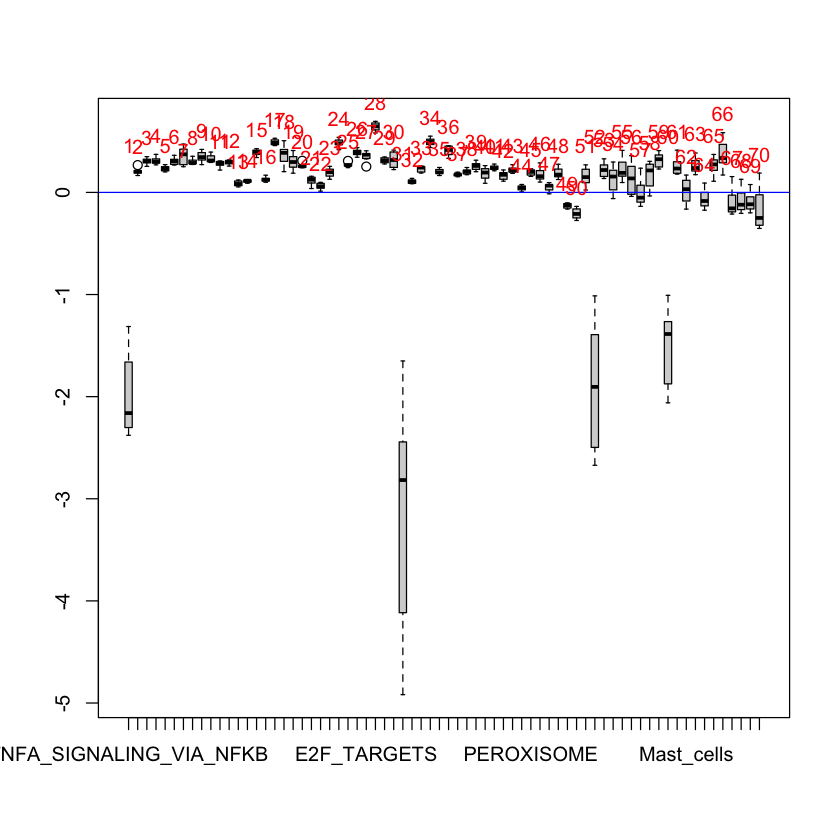

In [30]:
hc2 = hc
hc2[,c(1,31,52,60)] = log(hc[,c(1,31,52,60)]) 
hc2[,c(7)] = sqrt(hc[,c(7)])
boxplot(hc2,col="light gray")
abline(h=0,col="blue")
text(1:p,apply(hc,2,max),1:p,col="red",pos=3)


In [31]:
# COMMENT AJS:
# - Do we need the transformations above?
# - Are those correct?

### Potential different meanings of dimension, thus scale explanatory variables

In [32]:
hc_scaled <- apply(hc, 2, scale, center=TRUE, scale=TRUE)

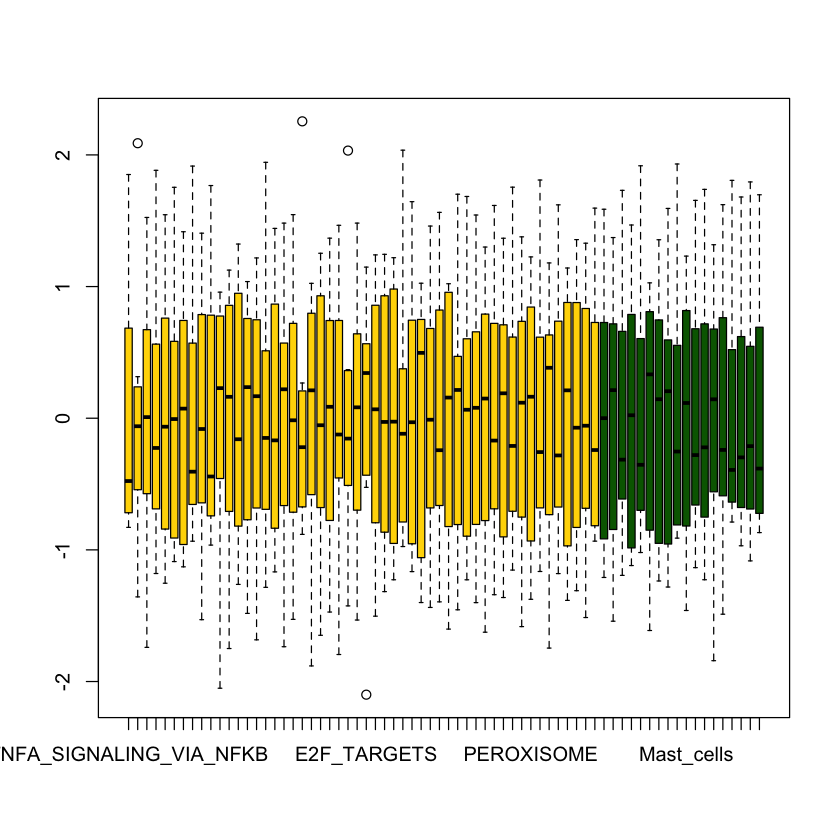

In [33]:
boxplot(hc_scaled, col=colors)

In [34]:
dim(hc_scaled)

[1]  8 70

##### Note: 70 explanatory variables, 8 data points. n << p

In [35]:
# cor bw hc and t
cor.t.hc_scaled = apply(hc_scaled,2,function(x,y){cor(x,y)},y=t)

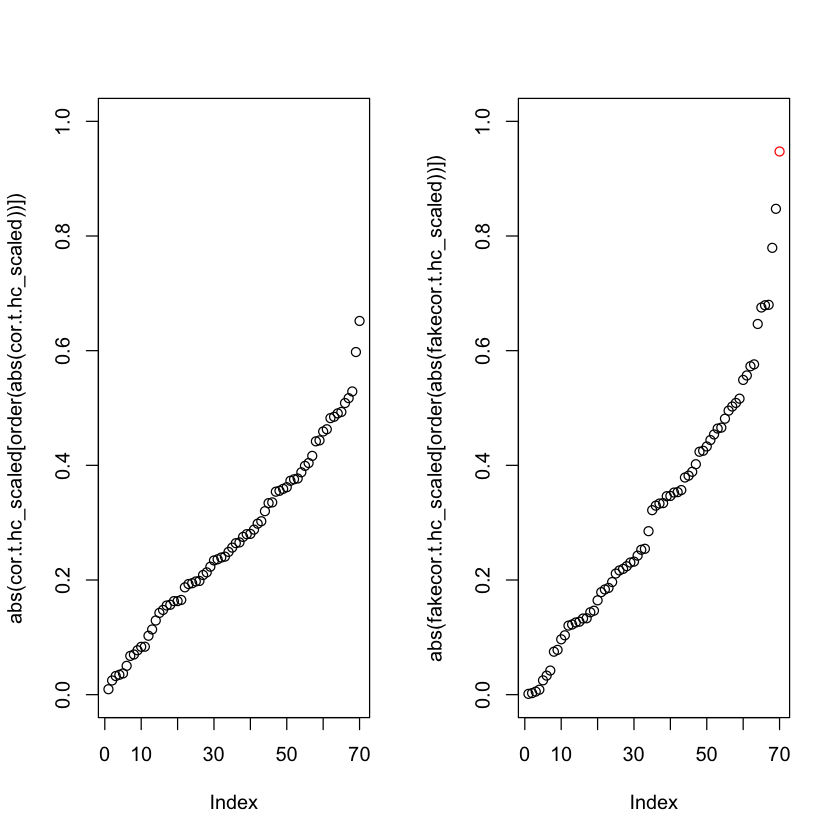

In [36]:
fake.hc_scaled = apply(matrix(rnorm(n*p),ncol=p),2,scale,center=TRUE,scale=TRUE)
fake.hc_scaled[,1] = scale(t+rnorm(n,0,.15),center=TRUE,scale=TRUE)
fakecor.t.hc_scaled = apply(fake.hc_scaled,2,function(x,y){cor(x,y)},y=t)
par(mfrow=c(1,2))
plot(abs(cor.t.hc_scaled[order(abs(cor.t.hc_scaled))]),ylim=c(0,1))
plot(abs(fakecor.t.hc_scaled[order(abs(fakecor.t.hc_scaled))]),
     ylim=c(0,1),col=rep(2:1,c(1,p-1))[order(abs(fakecor.t.hc_scaled))])

In [37]:
fake.hc_scaled = fake.hc_scaled[,order(abs(fakecor.t.hc_scaled),decreasing=TRUE)]

In [38]:
# COMMENT:
# - not much room for optimism

## LASSO regression all scaled features: Hallmarks + Consensus REAL DATA

### Automatic selection of lambda 

In [39]:
cv.fit_hc_scaled <- cv.glmnet(hc_scaled, t, family="gaussian", maxit = 1e+5, grouped=FALSE)


### Fit (assuming alpha=1)


In [40]:
fit_hc_scaled <- glmnet(hc_scaled, t, family =  "gaussian", maxit = 1e+5, standardize=FALSE)


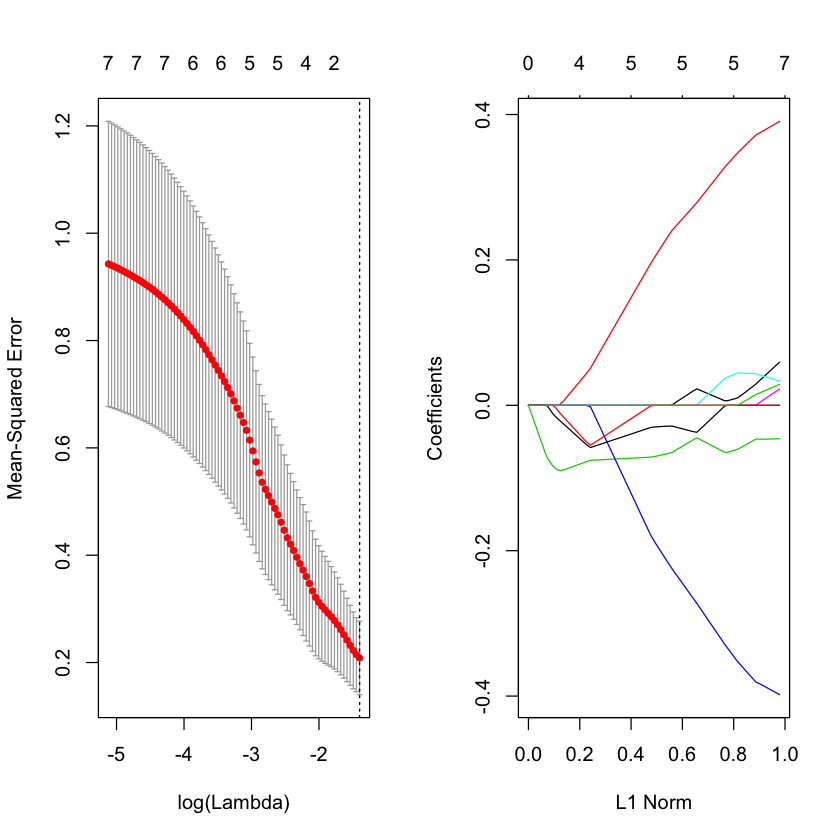

In [41]:
par(mfrow=c(1,2))
plot(cv.fit_hc_scaled)
plot(fit_hc_scaled)

### Results

In [42]:
Coefficients <- coef(fit_hc_scaled, s = cv.fit_hc_scaled$lambda.min)
Active.Index <- which(Coefficients != 0)
Active.Coefficients  <- Coefficients[Active.Index]

Active.Index
Active.Coefficients

[1] 1

[1] 0.4689456

In [43]:
cv.fit_hc_scaled2 <- cv.glmnet(
    hc_scaled,
    t,
    family="gaussian",
    maxit = 1e+5,
    grouped=FALSE,
    standardize=FALSE,
    alpha=1)

coef(cv.fit_hc_scaled2, s = "lambda.min")

71 x 1 sparse Matrix of class "dgCMatrix"
                                          1
(Intercept)                       0.4689456
TNFA_SIGNALING_VIA_NFKB           .        
HYPOXIA                           .        
CHOLESTEROL_HOMEOSTASIS           .        
MITOTIC_SPINDLE                   .        
WNT_BETA_CATENIN_SIGNALING        .        
TGF_BETA_SIGNALING                .        
IL6_JAK_STAT3_SIGNALING           .        
DNA_REPAIR                        .        
G2M_CHECKPOINT                    .        
APOPTOSIS                         .        
NOTCH_SIGNALING                   .        
ADIPOGENESIS                      .        
ESTROGEN_RESPONSE_EARLY           .        
ESTROGEN_RESPONSE_LATE            .        
ANDROGEN_RESPONSE                 .        
MYOGENESIS                        .        
PROTEIN_SECRETION                 .        
INTERFERON_ALPHA_RESPONSE         .        
INTERFERON_GAMMA_RESPONSE         .        
APICAL_JUNCTION                   

In [44]:
# COMMENT:
# - only intercept remaining: n=8, p=70...

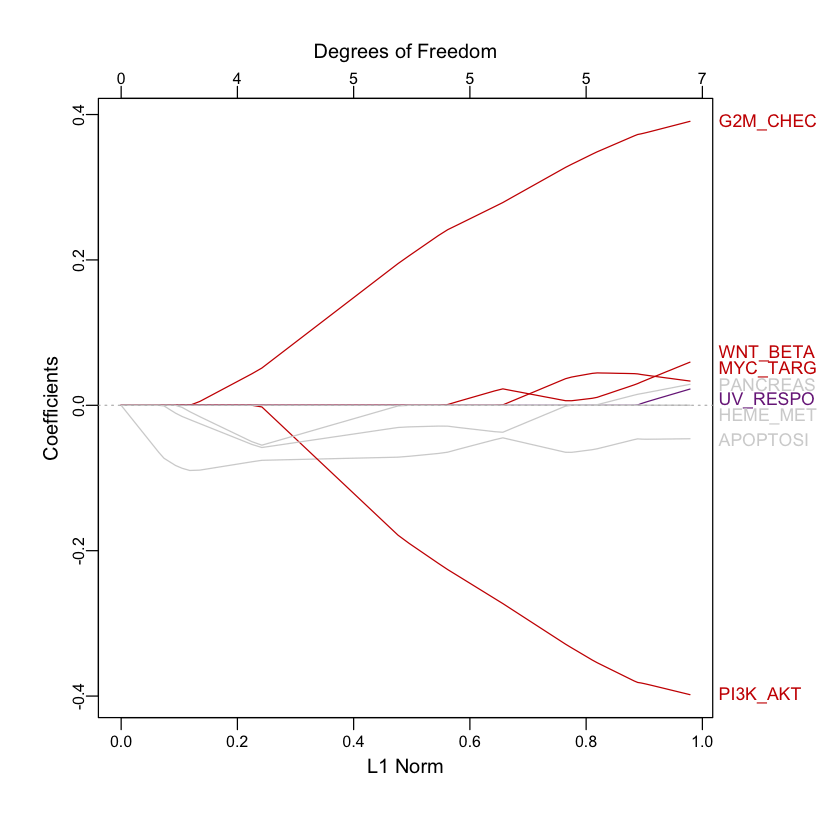

In [45]:
#pdf("../2.Plots/6_f_LASSO_HallmarksConsensus.pdf",width=6,height=4,paper='special') 
plot_glmnet(fit_hc_scaled, label=8, xvar="norm",
            col=c("#CC0000",
                  "#CC0000",
                  "#CC0000",
                  "#D3D3D3",
                  "#7A2989",
                  "#D3D3D3",
                  "#D3D3D3",
                  "#D3D3D3",
                  "#CC0000"
                 ))          # label the largets final coefs
#dev.off()

<p>
https://stats.stackexchange.com/questions/68431/interpretting-lasso-variable-trace-plots
</p>
<p style='text-align: justify;'>
The L1 norm is the regularization term for LASSO. Perhaps a better way to look at it is that the x-axis is the maximum permissible value the L1 norm can take. So when you have a small L1 norm, you have a lot of regularization. Therefore, an L1 norm of zero gives an empty model, and as you increase the L1 norm, variables will "enter" the model as their coefficients take non-zero values.
</p>

<p style='text-align: justify;'>
If you're trying to determine your strongest predictors, you could interpret the plot as evidence that variables that enter the model early (left) are the most predictive and variables that enter the model later are less important... Variables with zeroed-coeffiecients are not useful.
</p>

### Since different pathway NES could reflect different tumor population adn for completeness of the comparions, we performed the above analsysis without scaling

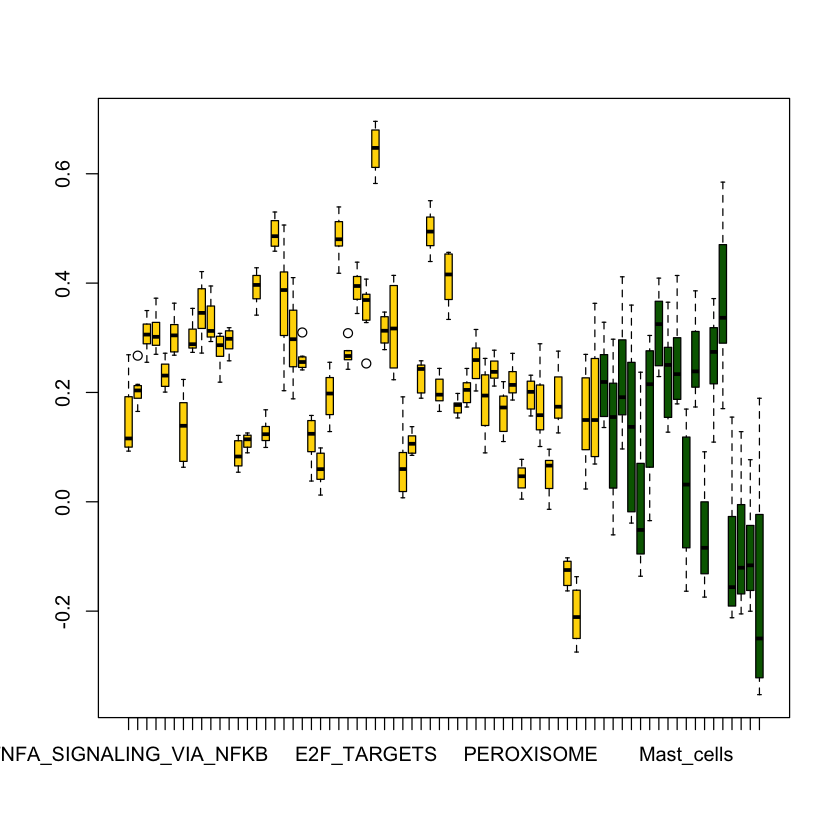

In [46]:
boxplot(hc, col=colors)

In [47]:
# cor bw hc and t
cor.t.hc = apply(hc,2,function(x,y){cor(x,y)},y=t)

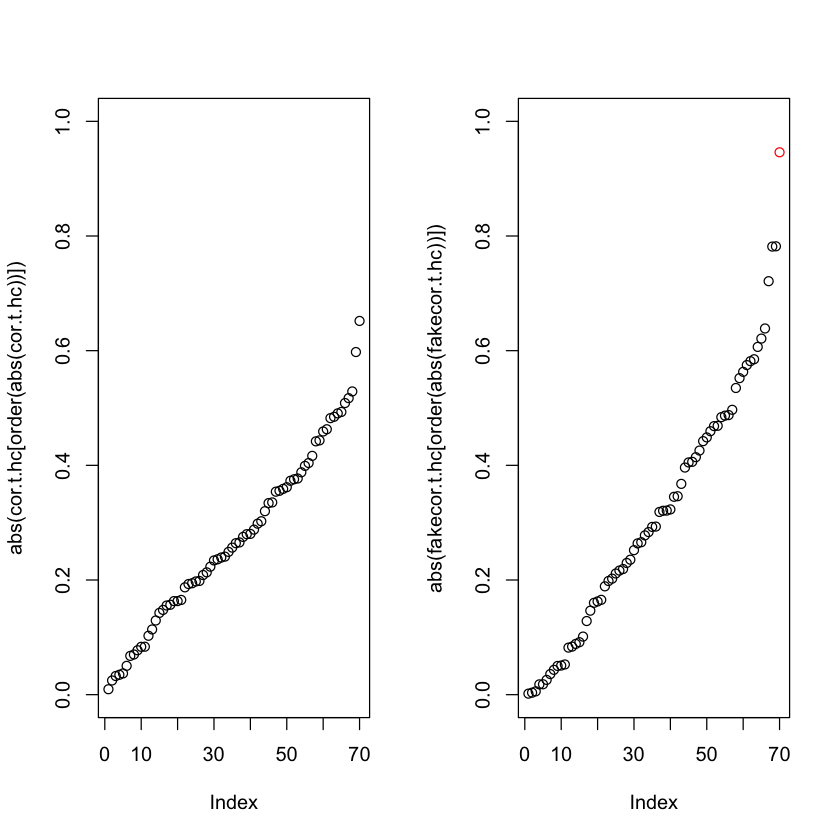

In [48]:
fake.hc = apply(matrix(rnorm(n*p),ncol=p),2,scale,center=TRUE,scale=TRUE)
fake.hc[,1] = scale(t+rnorm(n,0,.15),center=TRUE,scale=TRUE)
fakecor.t.hc = apply(fake.hc,2,function(x,y){cor(x,y)},y=t)
par(mfrow=c(1,2))
plot(abs(cor.t.hc[order(abs(cor.t.hc))]),ylim=c(0,1))
plot(abs(fakecor.t.hc[order(abs(fakecor.t.hc))]),
     ylim=c(0,1),col=rep(2:1,c(1,p-1))[order(abs(fakecor.t.hc))])

In [49]:
fake.hc = fake.hc[,order(abs(fakecor.t.hc),decreasing=TRUE)]

In [50]:
# COMMENT:
# - not much room for optimism

## LASSO regression all unscaled features: Hallmarks + Consensus REAL DATA

### Automatic selection of lambda 


In [51]:
cv.fit_hc <- cv.glmnet(hc, t, family="gaussian", maxit = 1e+5, grouped=FALSE)


### Fit (assuming alpha=1)


In [52]:
fit_hc <- glmnet(hc, t, family =  "gaussian", maxit = 1e+5, standardize=FALSE)


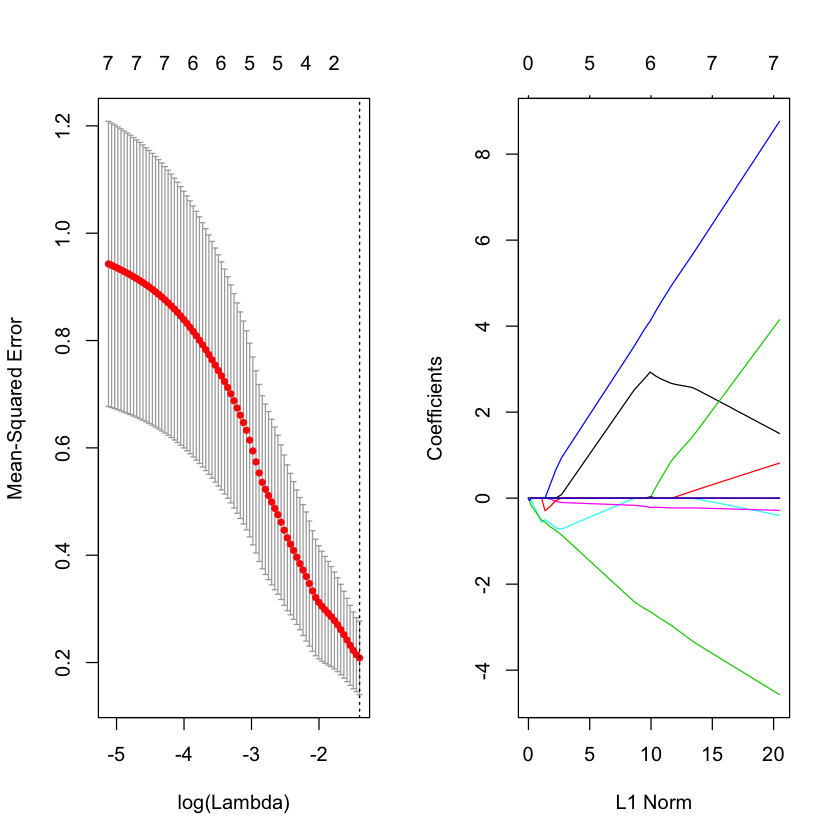

In [53]:
par(mfrow=c(1,2))
plot(cv.fit_hc)
plot(fit_hc)

### Results

In [54]:
Coefficients <- coef(fit_hc, s = cv.fit_hc$lambda.min)
Active.Index <- which(Coefficients != 0)
Active.Coefficients  <- Coefficients[Active.Index]

Active.Index
Active.Coefficients

[1] 1

[1] 0.4689456

In [55]:
cv.fit_hc2 <- cv.glmnet(
    hc,
    t,
    family="gaussian",
    maxit = 1e+5,
    grouped=FALSE,
    standardize=FALSE,
    alpha=1)

coef(cv.fit_hc2, s = "lambda.min")

71 x 1 sparse Matrix of class "dgCMatrix"
                                          1
(Intercept)                       0.4689456
TNFA_SIGNALING_VIA_NFKB           .        
HYPOXIA                           .        
CHOLESTEROL_HOMEOSTASIS           .        
MITOTIC_SPINDLE                   .        
WNT_BETA_CATENIN_SIGNALING        .        
TGF_BETA_SIGNALING                .        
IL6_JAK_STAT3_SIGNALING           .        
DNA_REPAIR                        .        
G2M_CHECKPOINT                    .        
APOPTOSIS                         .        
NOTCH_SIGNALING                   .        
ADIPOGENESIS                      .        
ESTROGEN_RESPONSE_EARLY           .        
ESTROGEN_RESPONSE_LATE            .        
ANDROGEN_RESPONSE                 .        
MYOGENESIS                        .        
PROTEIN_SECRETION                 .        
INTERFERON_ALPHA_RESPONSE         .        
INTERFERON_GAMMA_RESPONSE         .        
APICAL_JUNCTION                   

In [56]:
# COMMENT:
# - only intercept remaining: n=8, p=70...

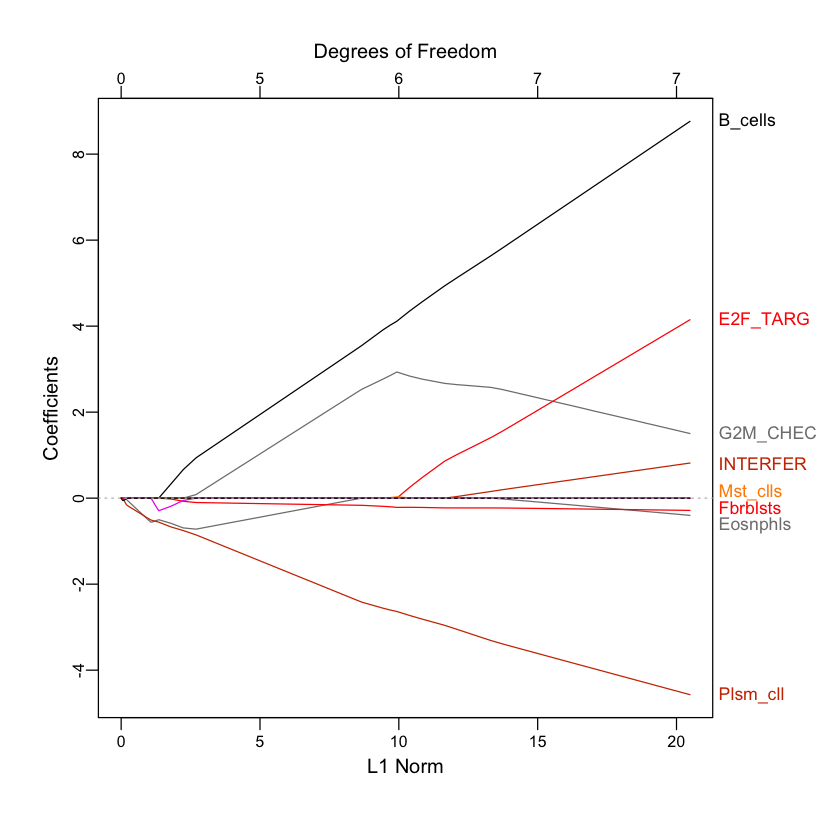

In [57]:
#pdf("../2.Plots/6_f_LASSO_HallmarksConsensus.pdf",width=6,height=4,paper='special') 
plot_glmnet(fit_hc, label=8, xvar="norm")          # label the largets final coefs
#dev.off()

In [58]:
# CONCLUSION_AJS:
# - same results/conclusion with or without scaling

# Focus on shorter predictor list

## Select only Hallmarks to compare within

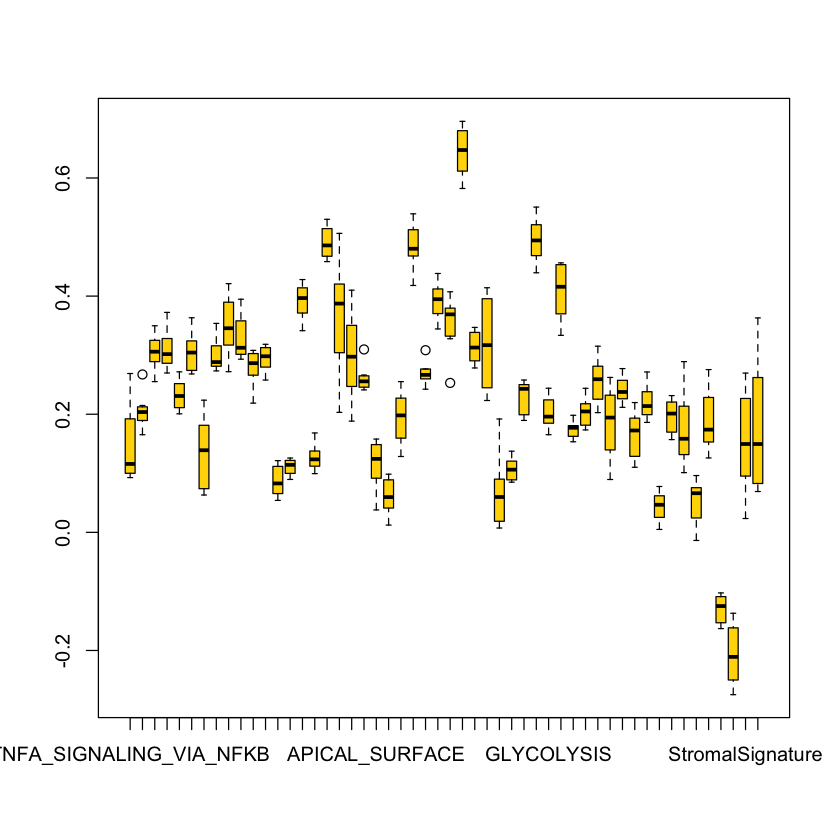

In [59]:
boxplot(h, col=c("gold"))

## Size

In [60]:
n = nrow(h)
p = ncol(h)
n
p

[1] 8

[1] 52

### Check h matrix before standardisation


#### Check relationship between h variables by performing pca on transposed h matrix

In [61]:
pr.var = princomp(t(h),cor=TRUE)

In [62]:
head(cor(h))

TNFA_SIGNALING_VIA_NFKB HYPOXIA   
TNFA_SIGNALING_VIA_NFKB     1.00000000              0.8378047
HYPOXIA                     0.83780471              1.0000000
CHOLESTEROL_HOMEOSTASIS     0.03534213              0.1362285
MITOTIC_SPINDLE            -0.08454371              0.2530826
WNT_BETA_CATENIN_SIGNALING -0.64114227             -0.2945605
TGF_BETA_SIGNALING          0.67357482              0.7888147
                           CHOLESTEROL_HOMEOSTASIS MITOTIC_SPINDLE
TNFA_SIGNALING_VIA_NFKB     0.03534213             -0.08454371    
HYPOXIA                     0.13622847              0.25308255    
CHOLESTEROL_HOMEOSTASIS     1.00000000             -0.10320814    
MITOTIC_SPINDLE            -0.10320814              1.00000000    
WNT_BETA_CATENIN_SIGNALING  0.17248467              0.52491323    
TGF_BETA_SIGNALING         -0.22464499              0.07901500    
                           WNT_BETA_CATENIN_SIGNALING TGF_BETA_SIGNALING
TNFA_SIGNALING_VIA_NFKB    -0.6411423                  0.6735748        
HYPOXIA                    -0.2945605                  0.7888147        
CHOLESTEROL_HOMEOSTASIS     0.1724847                 -0.2246450        
MITOTIC_SPINDLE             0.5249132                  0.0790150        
WNT_BETA_CATENIN_SIGNALING  1.0000000                 -0.3676381        
TGF_BETA_SIGNALING         -0.3676381                  1.0000000        
                           IL6_JAK_STAT3_SIGNALING DNA_REPAIR  G2M_CHECKPOINT
TNFA_SIGNALING_VIA_NFKB     0.9068651              -0.21732856 -0.4520212    
HYPOXIA                     0.8512841               0.21126097  0.0322958    
CHOLESTEROL_HOMEOSTASIS     0.1533010               0.23471816  0.2756434    
MITOTIC_SPINDLE             0.1775419               0.84635237  0.6956988    
WNT_BETA_CATENIN_SIGNALING -0.3691729               0.75937515  0.5630129    
TGF_BETA_SIGNALING          0.6613366               0.09949435 -0.1080564    
                           APOPTOSIS  ⋯ IL2_STAT5_SIGNALING
TNFA_SIGNALING_VIA_NFKB     0.8844528 ⋯  0.93531284        
HYPOXIA                     0.7699170 ⋯  0.90259955        
CHOLESTEROL_HOMEOSTASIS    -0.1423744 ⋯ -0.09343186        
MITOTIC_SPINDLE             0.2470769 ⋯  0.18219654        
WNT_BETA_CATENIN_SIGNALING -0.3706946 ⋯ -0.50678308        
TGF_BETA_SIGNALING          0.5129042 ⋯  0.79178824        
                           BILE_ACID_METABOLISM PEROXISOME  ALLOGRAFT_REJECTION
TNFA_SIGNALING_VIA_NFKB     0.29831131           0.04117829  0.92227593        
HYPOXIA                    -0.13237760           0.17886270  0.84096897        
CHOLESTEROL_HOMEOSTASIS     0.11027631           0.30062382  0.02348246        
MITOTIC_SPINDLE            -0.68286016           0.34145001  0.23367716        
WNT_BETA_CATENIN_SIGNALING -0.30175129           0.40658048 -0.34828474        
TGF_BETA_SIGNALING         -0.03518394          -0.15520672  0.63218264        
                           SPERMATOGENESIS KRAS_SIGNALING_UP KRAS_SIGNALING_DN
TNFA_SIGNALING_VIA_NFKB    -0.6880069       0.8575903        -0.07230680      
HYPOXIA                    -0.6354787       0.8006475        -0.33937074      
CHOLESTEROL_HOMEOSTASIS     0.3714840      -0.2535844        -0.52694179      
MITOTIC_SPINDLE            -0.1210168       0.2288884        -0.65018661      
WNT_BETA_CATENIN_SIGNALING  0.2102290      -0.3756786        -0.24806206      
TGF_BETA_SIGNALING         -0.7727229       0.8234393        -0.09057618      
                           PANCREAS_BETA_CELLS StromalSignature ImmuneSignature
TNFA_SIGNALING_VIA_NFKB     0.03203793          0.7837151        0.8793944     
HYPOXIA                     0.03461745          0.6457980        0.7715494     
CHOLESTEROL_HOMEOSTASIS    -0.18015710         -0.0556941       -0.1683449     
MITOTIC_SPINDLE            -0.65841777          0.2444151        0.2175435     
WNT_BETA_CATENIN_SIGNALING -0.41457324         -0.2688253       -0.3174635     
TGF_BETA_SIGNALING          0.17801277          0.6308

In [63]:
summary(pr.var)

Importance of components:
                          Comp.1     Comp.2      Comp.3      Comp.4     Comp.5
Standard deviation     2.7482641 0.52198065 0.222158123 0.208452068 0.17676629
Proportion of Variance 0.9441194 0.03405797 0.006169279 0.005431533 0.00390579
Cumulative Proportion  0.9441194 0.97817739 0.984346669 0.989778202 0.99368399
                            Comp.6      Comp.7    Comp.8
Standard deviation     0.150896138 0.135575884 0.0968380
Proportion of Variance 0.002846206 0.002297603 0.0011722
Cumulative Proportion  0.996530198 0.998827800 1.0000000

In [64]:
pr.var[[2]]


Loadings:
    Comp.1 Comp.2 Comp.3 Comp.4 Comp.5 Comp.6 Comp.7 Comp.8
A01  0.352  0.392  0.405  0.308  0.495  0.258  0.366  0.134
A03  0.341 -0.637  0.254  0.209        -0.530  0.297       
A05  0.353  0.316 -0.696 -0.121  0.178 -0.367  0.277 -0.181
A07  0.358  0.146  0.170 -0.514 -0.553         0.293  0.401
A11  0.361               -0.162  0.324 -0.250 -0.689  0.446
B02  0.361         0.311 -0.344         0.104 -0.246 -0.762
B04  0.347 -0.523 -0.386         0.123  0.661              
B06  0.356  0.206 -0.103  0.662 -0.545        -0.282       

               Comp.1 Comp.2 Comp.3 Comp.4 Comp.5 Comp.6 Comp.7 Comp.8
SS loadings     1.000  1.000  1.000  1.000  1.000  1.000  1.000  1.000
Proportion Var  0.125  0.125  0.125  0.125  0.125  0.125  0.125  0.125
Cumulative Var  0.125  0.250  0.375  0.500  0.625  0.750  0.875  1.000

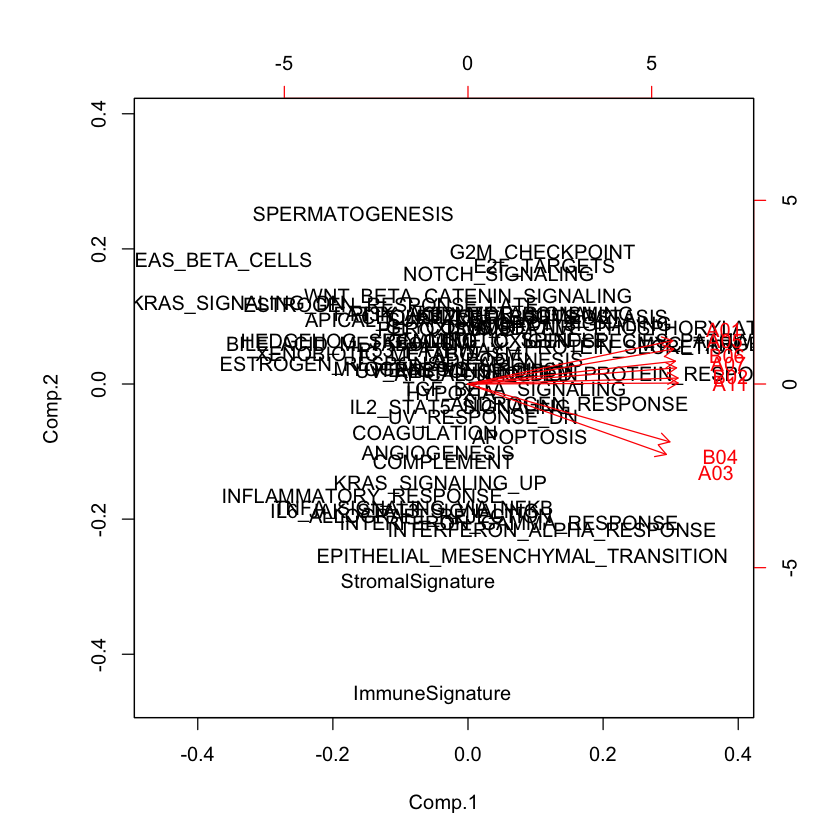

In [65]:
biplot(pr.var)

In [66]:
# COMMENT
# - 90% of the var = mean...

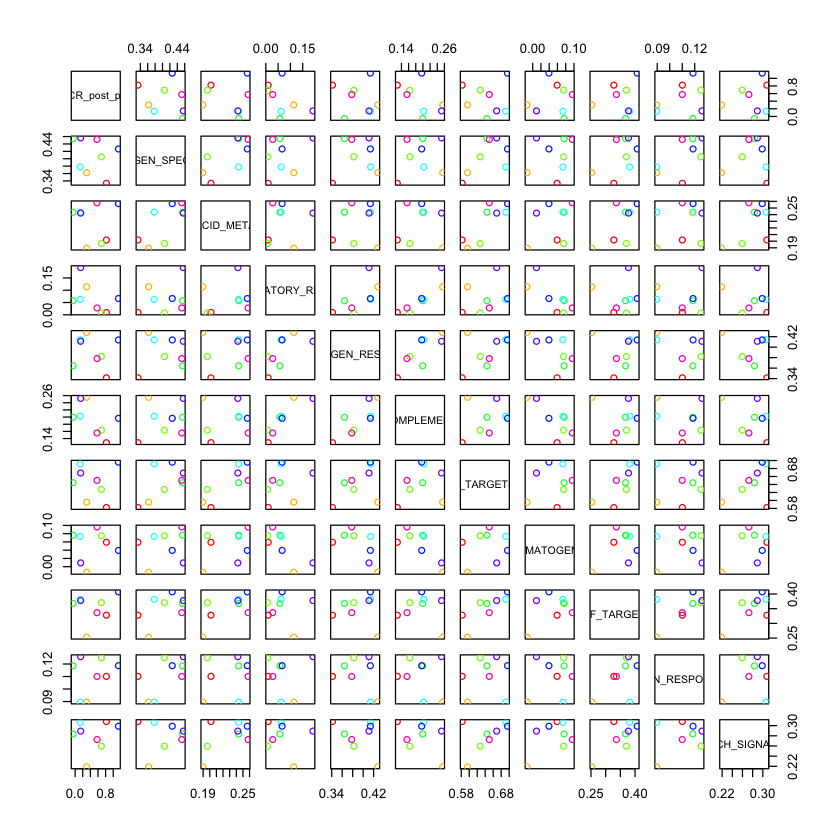

In [67]:
pairs(cbind(t,h[,order(runif(p))[1:10]]),col=rainbow(n))

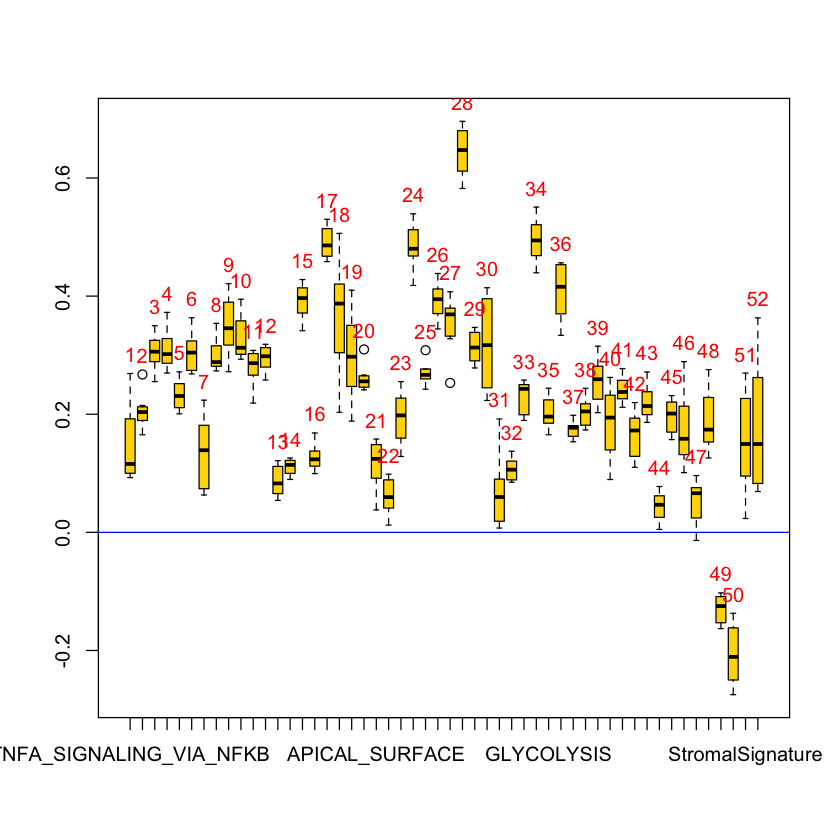

In [68]:
boxplot(h,col=colors)
abline(h=0,col="blue")
text(1:p,apply(h,2,max),1:p,col="red",pos=3)

In [69]:
h_scaled <- apply(h, 2, scale, center=TRUE, scale=TRUE)

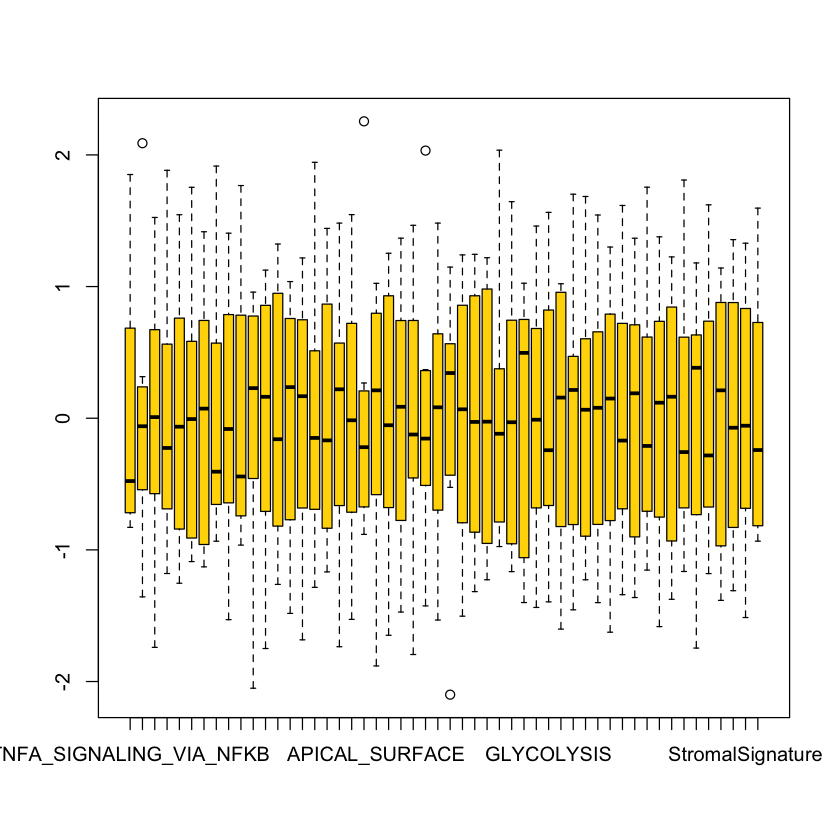

In [70]:
boxplot(h_scaled, col=colors)

In [71]:
dim(h_scaled)

[1]  8 52

In [72]:
##### Note: 52 explanatory variables, 8 data points. n << p

In [73]:
# cor bw hc and t
cor.t.h_scaled = apply(h_scaled,2,function(x,y){cor(x,y)},y=t)

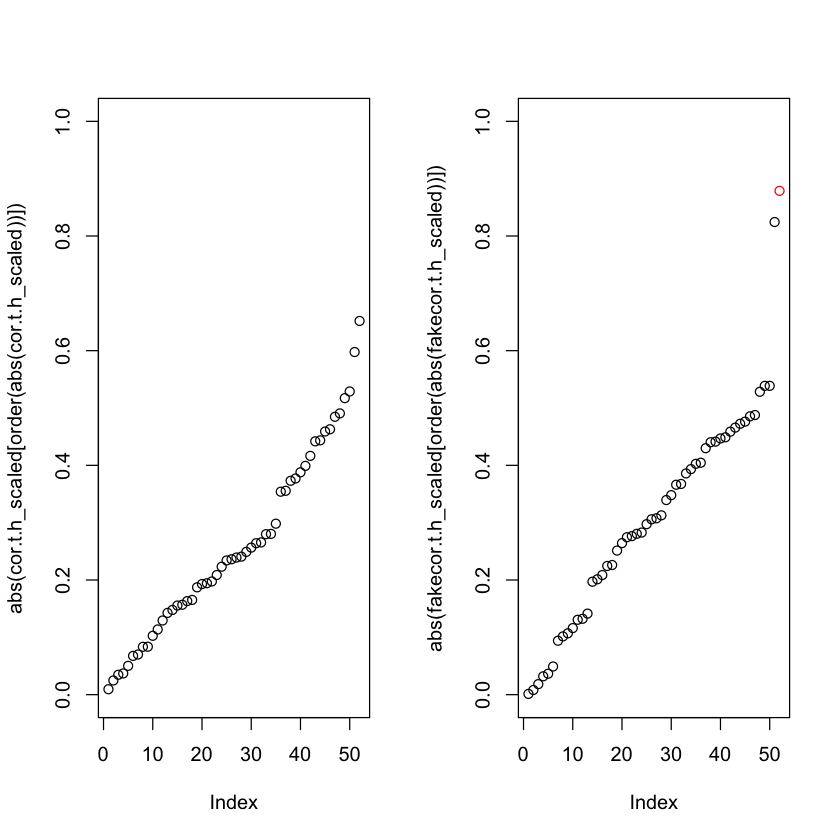

In [74]:
fake.h_scaled = apply(matrix(rnorm(n*p),ncol=p),2,scale,center=TRUE,scale=TRUE)
fake.h_scaled[,1] = scale(t+rnorm(n,0,.15),center=TRUE,scale=TRUE)
fakecor.t.h_scaled = apply(fake.h_scaled,2,function(x,y){cor(x,y)},y=t)
par(mfrow=c(1,2))
plot(abs(cor.t.h_scaled[order(abs(cor.t.h_scaled))]),ylim=c(0,1))
plot(abs(fakecor.t.h_scaled[order(abs(fakecor.t.h_scaled))]),
     ylim=c(0,1),col=rep(2:1,c(1,p-1))[order(abs(fakecor.t.h_scaled))])

In [75]:
fake.h_scaled = fake.h_scaled[,order(abs(fakecor.t.h_scaled),decreasing=TRUE)]

In [76]:
# COMMENT:
# - not much room for optimism

## LASSO regression all scaled features: Hallmarks REAL DATA

### Automatic selection of lambda 


In [77]:
cv.fit_h_scaled <- cv.glmnet(h_scaled, t, family="gaussian", maxit = 1e+5, grouped=FALSE)


### Fit (assuming alpha=1)


In [78]:
fit_h_scaled <- glmnet(h_scaled, t, family =  "gaussian", maxit = 1e+5, standardize=FALSE)


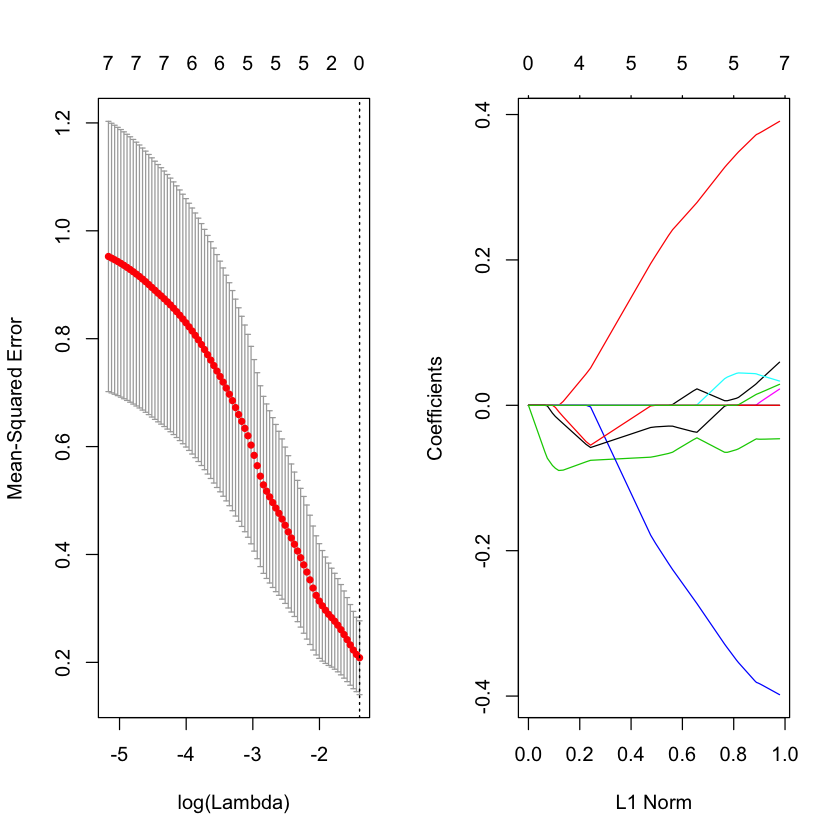

In [79]:
par(mfrow=c(1,2))
plot(cv.fit_h_scaled)
plot(fit_h_scaled)

### Results

In [80]:
Coefficients <- coef(fit_h_scaled, s = cv.fit_h_scaled$lambda.min)
Active.Index <- which(Coefficients != 0)
Active.Coefficients  <- Coefficients[Active.Index]

Active.Index
Active.Coefficients

[1] 1

[1] 0.4689456

In [81]:
cv.fit_h_scaled2 <- cv.glmnet(
    h_scaled,
    t,
    family="gaussian",
    maxit = 1e+5,
    grouped=FALSE,
    standardize=FALSE,
    alpha=1)

coef(cv.fit_h_scaled2, s = "lambda.min")

53 x 1 sparse Matrix of class "dgCMatrix"
                                          1
(Intercept)                       0.4689456
TNFA_SIGNALING_VIA_NFKB           .        
HYPOXIA                           .        
CHOLESTEROL_HOMEOSTASIS           .        
MITOTIC_SPINDLE                   .        
WNT_BETA_CATENIN_SIGNALING        .        
TGF_BETA_SIGNALING                .        
IL6_JAK_STAT3_SIGNALING           .        
DNA_REPAIR                        .        
G2M_CHECKPOINT                    .        
APOPTOSIS                         .        
NOTCH_SIGNALING                   .        
ADIPOGENESIS                      .        
ESTROGEN_RESPONSE_EARLY           .        
ESTROGEN_RESPONSE_LATE            .        
ANDROGEN_RESPONSE                 .        
MYOGENESIS                        .        
PROTEIN_SECRETION                 .        
INTERFERON_ALPHA_RESPONSE         .        
INTERFERON_GAMMA_RESPONSE         .        
APICAL_JUNCTION                   

In [82]:
# COMMENT:
# - only intercept remaining: n=8, p=52...

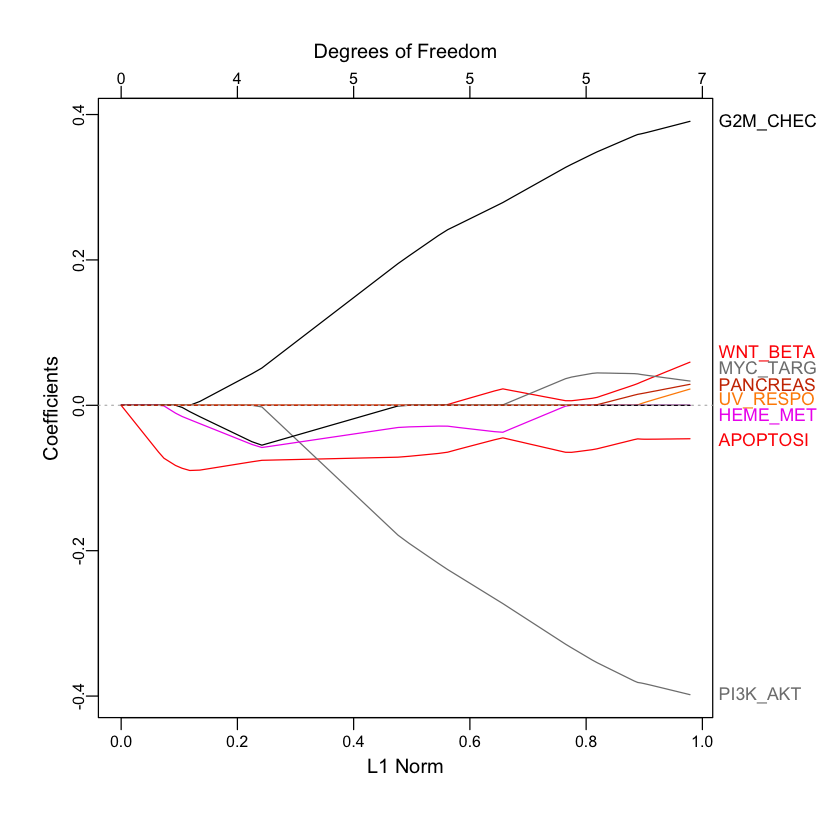

In [83]:
#pdf("../2.Plots/6_f_LASSO_HallmarksConsensus.pdf",width=6,height=4,paper='special') 
plot_glmnet(fit_h_scaled, label=8, xvar="norm")          # label the largets final coefs
#dev.off()

### Since different pathway NES could reflect different tumor population and for completeness of the comparions, we performed the above analsysis without scaling

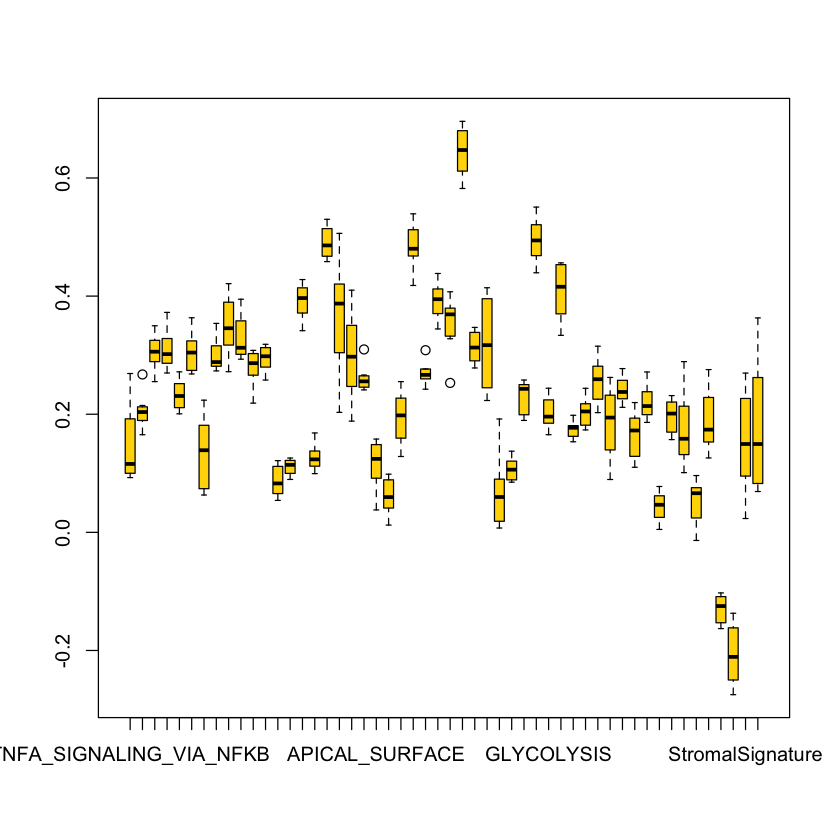

In [84]:
boxplot(h, col=c("gold"))

In [85]:
# cor bw hc and t
cor.t.h = apply(h,2,function(x,y){cor(x,y)},y=t)

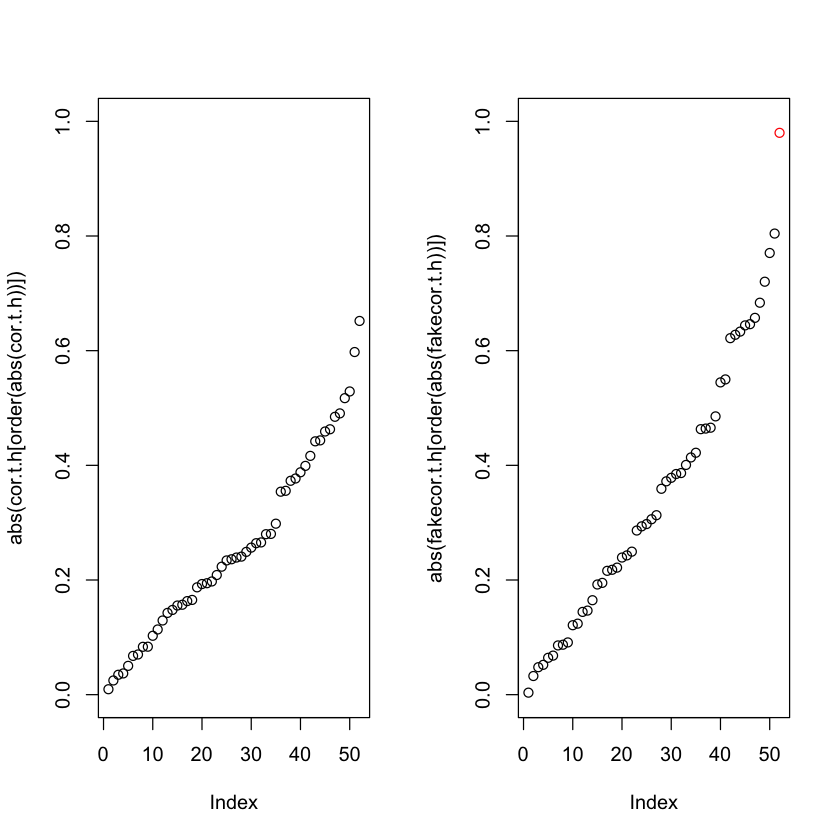

In [86]:
fake.h = apply(matrix(rnorm(n*p),ncol=p),2,scale,center=TRUE,scale=TRUE)
fake.h[,1] = scale(t+rnorm(n,0,.15),center=TRUE,scale=TRUE)
fakecor.t.h = apply(fake.h,2,function(x,y){cor(x,y)},y=t)
par(mfrow=c(1,2))
plot(abs(cor.t.h[order(abs(cor.t.h))]),ylim=c(0,1))
plot(abs(fakecor.t.h[order(abs(fakecor.t.h))]),
     ylim=c(0,1),col=rep(2:1,c(1,p-1))[order(abs(fakecor.t.h))])

In [87]:
fake.h = fake.h[,order(abs(fakecor.t.h),decreasing=TRUE)]

In [88]:
# COMMENT:
# - not much room for optimism

## LASSO regression unscaled features: Hallmarks REAL DATA


### Automatic selection of lambda 


In [89]:
cv.fit_h <- cv.glmnet(h, t, family="gaussian", maxit = 1e+5, grouped=FALSE)


### Fit (assuming alpha=1)


In [90]:
fit_h <- glmnet(h, t, family =  "gaussian", maxit = 1e+5, standardize=FALSE)


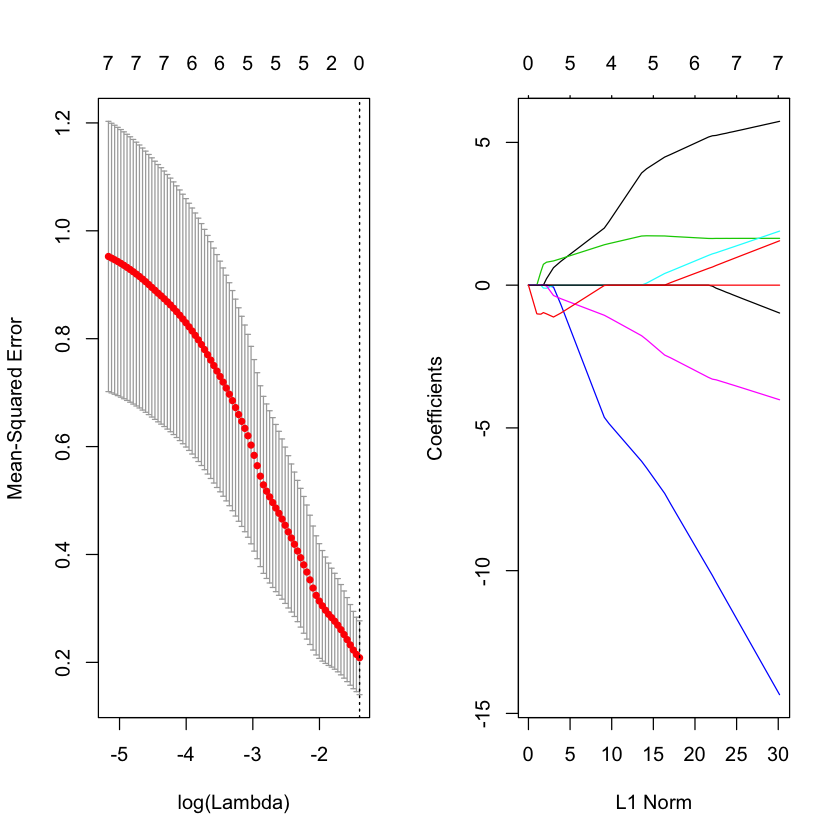

In [91]:
par(mfrow=c(1,2))
plot(cv.fit_h)
plot(fit_h)

### Results

In [92]:
Coefficients <- coef(fit_h, s = cv.fit_h$lambda.min)
Active.Index <- which(Coefficients != 0)
Active.Coefficients  <- Coefficients[Active.Index]

Active.Index
Active.Coefficients

[1] 1

[1] 0.4689456

In [93]:
cv.fit_h2 <- cv.glmnet(
    h,
    t,
    family="gaussian",
    maxit = 1e+5,
    grouped=FALSE,
    standardize=FALSE,
    alpha=1)

coef(cv.fit_h2, s = "lambda.min")

53 x 1 sparse Matrix of class "dgCMatrix"
                                           1
(Intercept)                        0.5625109
TNFA_SIGNALING_VIA_NFKB            .        
HYPOXIA                            .        
CHOLESTEROL_HOMEOSTASIS            .        
MITOTIC_SPINDLE                    .        
WNT_BETA_CATENIN_SIGNALING         .        
TGF_BETA_SIGNALING                 .        
IL6_JAK_STAT3_SIGNALING            .        
DNA_REPAIR                         .        
G2M_CHECKPOINT                     .        
APOPTOSIS                          .        
NOTCH_SIGNALING                    .        
ADIPOGENESIS                       .        
ESTROGEN_RESPONSE_EARLY            .        
ESTROGEN_RESPONSE_LATE             .        
ANDROGEN_RESPONSE                  .        
MYOGENESIS                         .        
PROTEIN_SECRETION                  .        
INTERFERON_ALPHA_RESPONSE          .        
INTERFERON_GAMMA_RESPONSE          .        
APICAL_JUNCTI

In [ ]:
# COMMENT_AJS
# - doesn't the above mean that Immunesignature is selected?

In [ ]:
# COMMENT:
# - only intercept remaining: n=8, p=52...

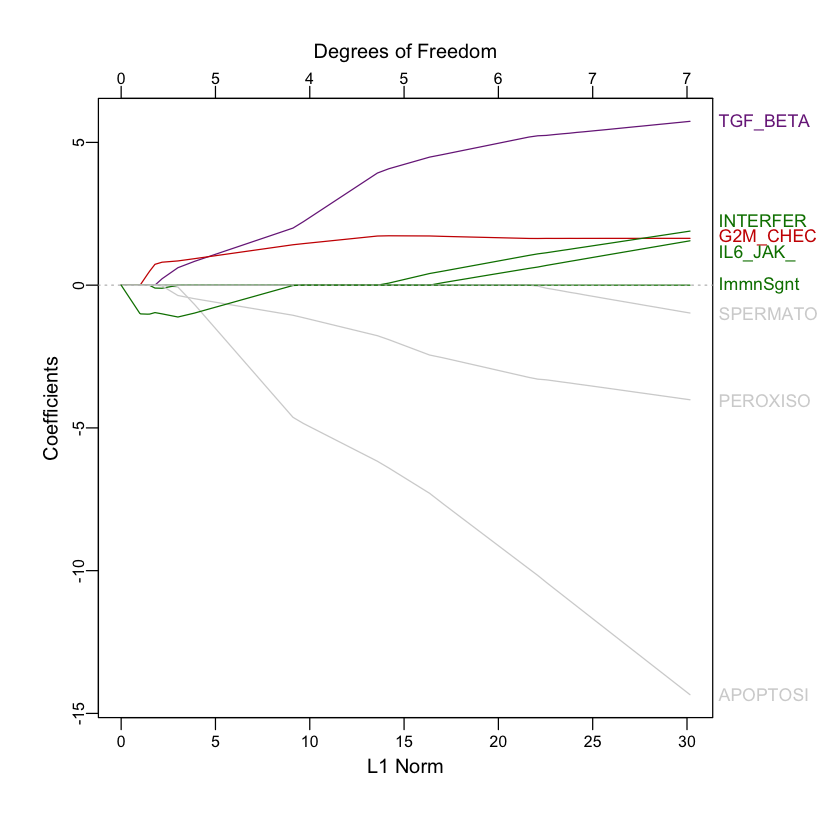

In [94]:
#pdf("../2.Plots/6_f_LASSO_HallmarksConsensus.pdf",width=6,height=4,paper='special') 
plot_glmnet(fit_h, label=8, xvar="norm",
            col=c('#7A2989',
                  '#007F00',
                  '#CC0000',
                  '#007F00',
                  '#007F00',
                  '#D3D3D3',
                  '#D3D3D3',
                  '#D3D3D3'
                 ))             # label the largets final coefs
#dev.off()

## Select only ConsensusTME to compare within

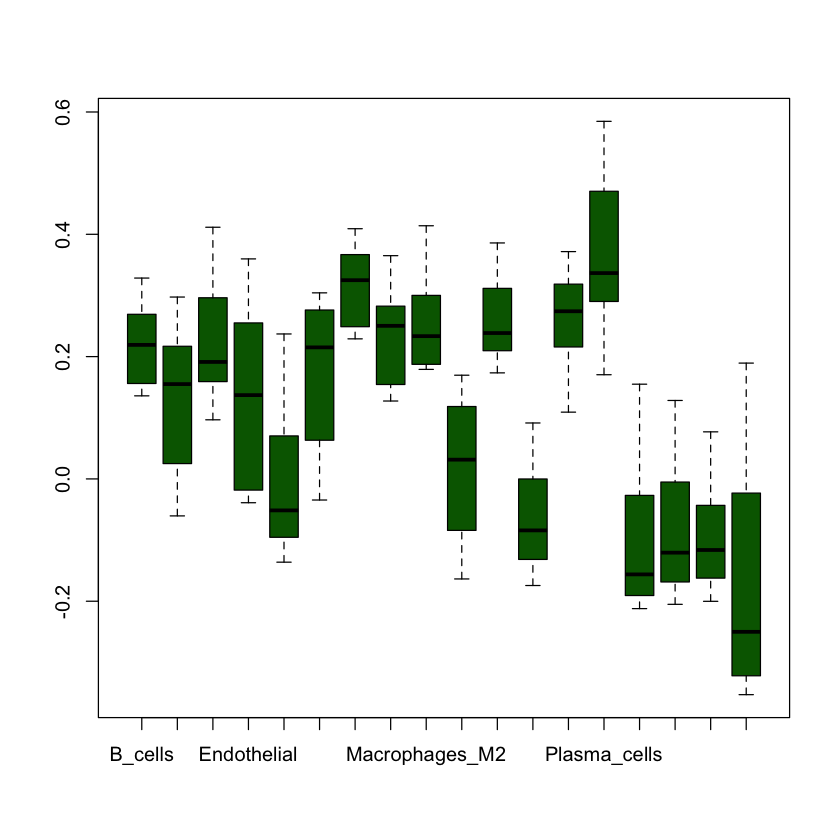

In [95]:
boxplot(c, col=c("darkgreen"))

### Size

In [96]:
n = nrow(c)
p = ncol(c)
n
p

[1] 8

[1] 18

### Check c matrix before standardisation



#### Check relationship between hc variables by performing pca on transposed hc matrix


In [97]:
pr.var = princomp(t(c),cor=TRUE)

In [98]:
head(cor(c))

B_cells   Cytotoxic_cells Dendritic_cells Endothelial
B_cells         1.0000000 0.6247114       0.8662571       0.9318249  
Cytotoxic_cells 0.6247114 1.0000000       0.7311468       0.5247936  
Dendritic_cells 0.8662571 0.7311468       1.0000000       0.9021366  
Endothelial     0.9318249 0.5247936       0.9021366       1.0000000  
Eosinophils     0.6199508 0.6924626       0.9016565       0.7031752  
Fibroblasts     0.4832722 0.3125638       0.4255881       0.5188327  
                Eosinophils Fibroblasts Macrophages Macrophages_M1
B_cells         0.6199508   0.4832722   0.5910914   0.6416555     
Cytotoxic_cells 0.6924626   0.3125638   0.4892587   0.1789371     
Dendritic_cells 0.9016565   0.4255881   0.7807949   0.7520081     
Endothelial     0.7031752   0.5188327   0.5924981   0.8244946     
Eosinophils     1.0000000   0.3994008   0.8784789   0.7167283     
Fibroblasts     0.3994008   1.0000000   0.2740943   0.3141331     
                Macrophages_M2 Mast_cells Monocytes NK_cells  Neutrophils
B_cells         0.6071668      0.3062924  0.7678398 0.7686214 0.1952300  
Cytotoxic_cells 0.7589505      0.4090971  0.7663691 0.9376615 0.5137504  
Dendritic_cells 0.8433001      0.4904089  0.8975607 0.8891995 0.4424248  
Endothelial     0.6454072      0.1897716  0.7336363 0.7009793 0.2878118  
Eosinophils     0.9613680      0.6077254  0.9090569 0.7922522 0.7258048  
Fibroblasts     0.4506307      0.3468929  0.3648212 0.2534220 0.5168975  
                Plasma_cells T_cells_CD4 T_cells_CD8 T_cells_gamma_delta
B_cells         0.7551956    0.8434945   0.8773281   0.8647656          
Cytotoxic_cells 0.6524827    0.7527964   0.7354073   0.7348964          
Dendritic_cells 0.8584969    0.9382043   0.9562447   0.9720735          
Endothelial     0.8774584    0.8674320   0.9246876   0.9229912          
Eosinophils     0.7678029    0.8833038   0.8741840   0.8939426          
Fibroblasts     0.6496535    0.4446196   0.4356923   0.4906370          
                T_regulatory_cells
B_cells         0.8593907         
Cytotoxic_cells 0.7452855         
Dendritic_cells 0.9416342         
Endothelial     0.9123450         
Eosinophils     0.8135422         
Fibroblasts     0.3047269

In [99]:
summary(pr.var)

Importance of components:
                          Comp.1     Comp.2     Comp.3     Comp.4     Comp.5
Standard deviation     2.6398138 0.69026408 0.43203534 0.34417594 0.33360917
Proportion of Variance 0.8710771 0.05955806 0.02333182 0.01480713 0.01391188
Cumulative Proportion  0.8710771 0.93063521 0.95396702 0.96877416 0.98268604
                            Comp.6      Comp.7       Comp.8
Standard deviation     0.268020938 0.248363233 0.0706550326
Proportion of Variance 0.008979403 0.007710537 0.0006240167
Cumulative Proportion  0.991665446 0.999375983 1.0000000000

In [100]:
pr.var[[2]]


Loadings:
    Comp.1 Comp.2 Comp.3 Comp.4 Comp.5 Comp.6 Comp.7 Comp.8
A01  0.362                0.312  0.755  0.211  0.367  0.128
A03  0.346  0.496 -0.258         0.136  0.146 -0.724       
A05  0.363 -0.111  0.282  0.475 -0.103 -0.688 -0.116 -0.232
A07  0.343 -0.523         0.328 -0.382  0.473 -0.170  0.318
A11  0.357  0.201 -0.608        -0.259 -0.303  0.386  0.386
B02  0.364 -0.309 -0.317 -0.281         0.146  0.132 -0.745
B04  0.338  0.511  0.528 -0.123 -0.386  0.275  0.305 -0.120
B06  0.356 -0.266  0.317 -0.684  0.195 -0.218 -0.199  0.330

               Comp.1 Comp.2 Comp.3 Comp.4 Comp.5 Comp.6 Comp.7 Comp.8
SS loadings     1.000  1.000  1.000  1.000  1.000  1.000  1.000  1.000
Proportion Var  0.125  0.125  0.125  0.125  0.125  0.125  0.125  0.125
Cumulative Var  0.125  0.250  0.375  0.500  0.625  0.750  0.875  1.000

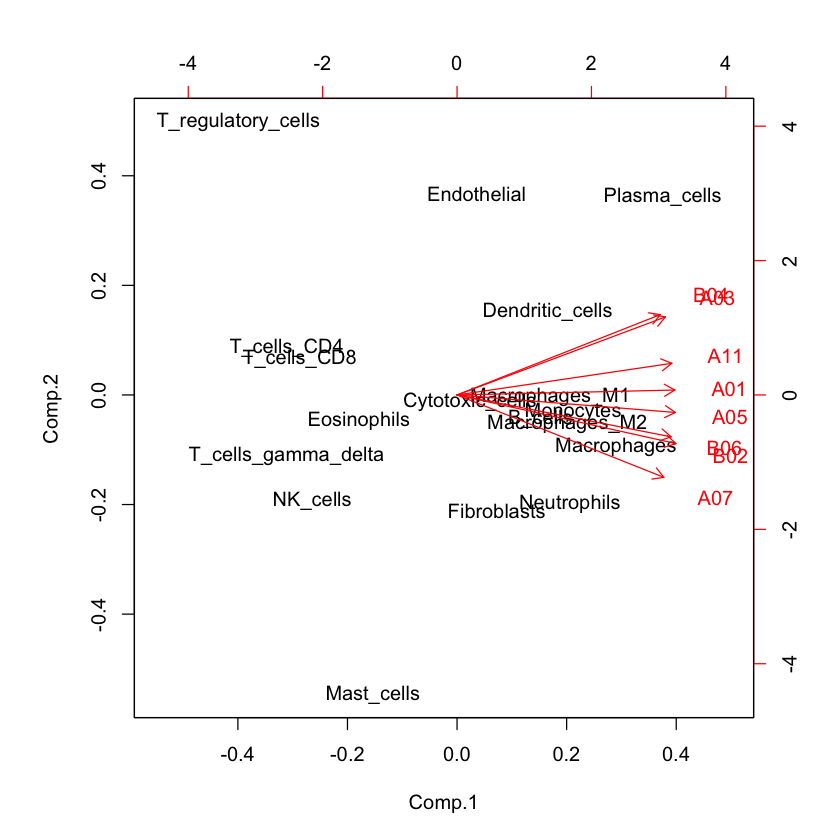

In [101]:
biplot(pr.var)

In [102]:
# COMMENT
# - 90% of the var = mean...

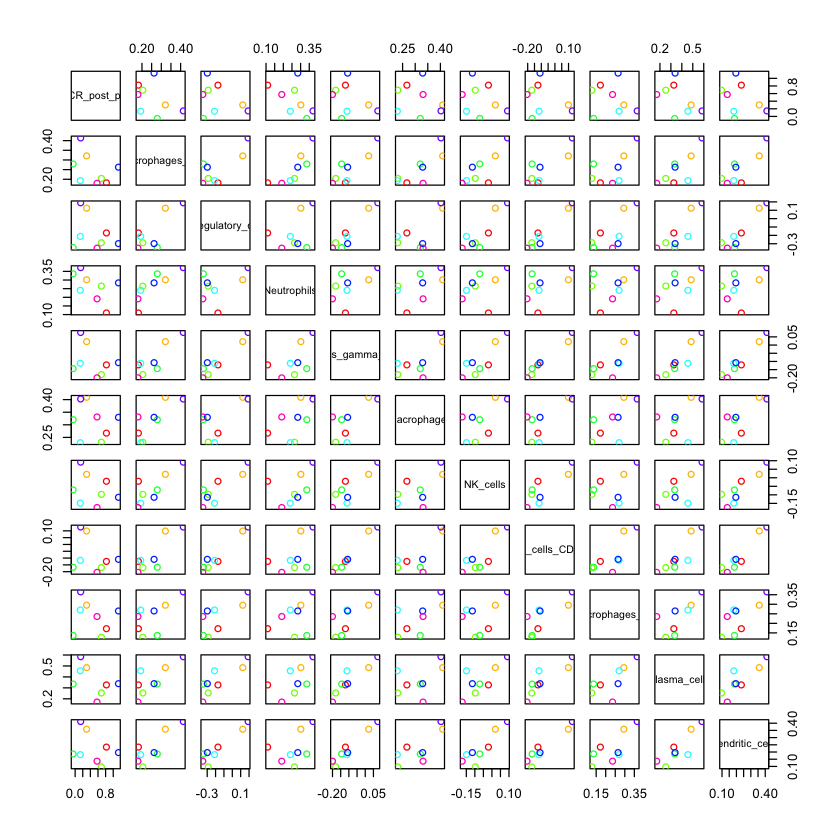

In [103]:
pairs(cbind(t,c[,order(runif(p))[1:10]]),col=rainbow(n))

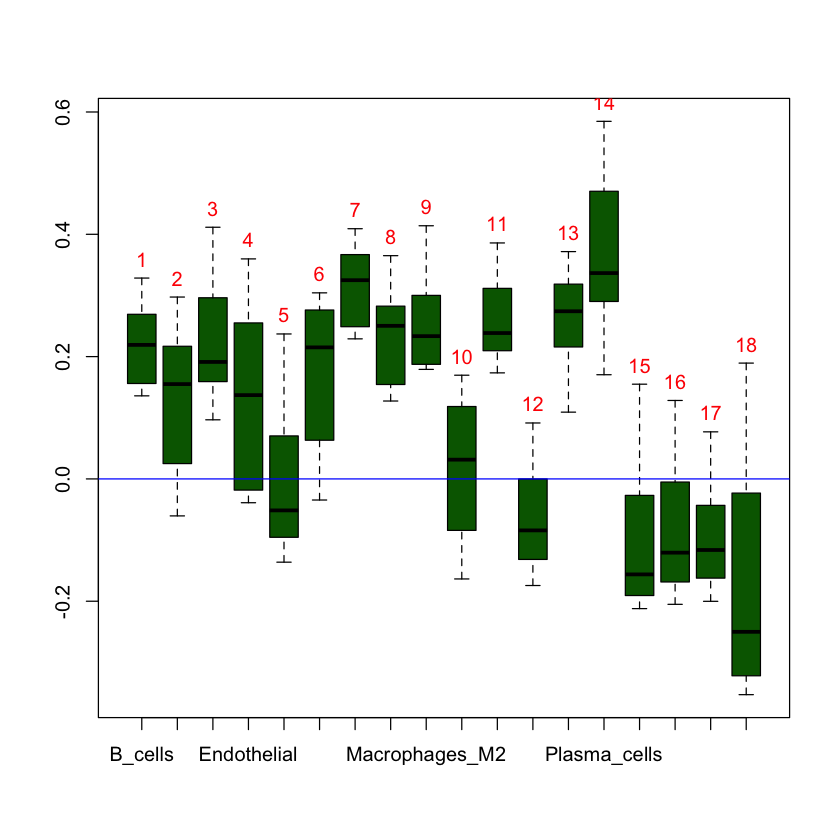

In [104]:
boxplot(c,col=c("darkgreen"))
abline(h=0,col="blue")
text(1:p,apply(c,2,max),1:p,col="red",pos=3)

In [105]:
c_scaled <- apply(c, 2, scale, center=TRUE, scale=TRUE)

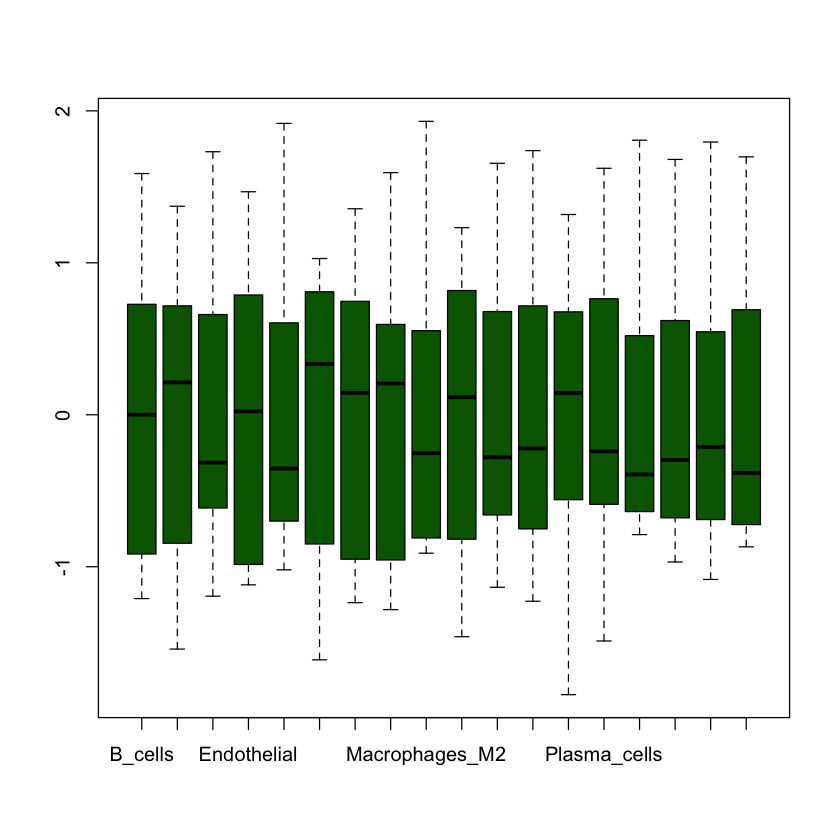

In [106]:
boxplot(c_scaled, col=c("darkgreen"))

In [107]:
dim(c_scaled)

[1]  8 18

In [108]:
##### Note: 18 explanatory variables, 8 data points. n < p

In [109]:
# cor bw hc and t
cor.t.c_scaled = apply(c_scaled,2,function(x,y){cor(x,y)},y=t)

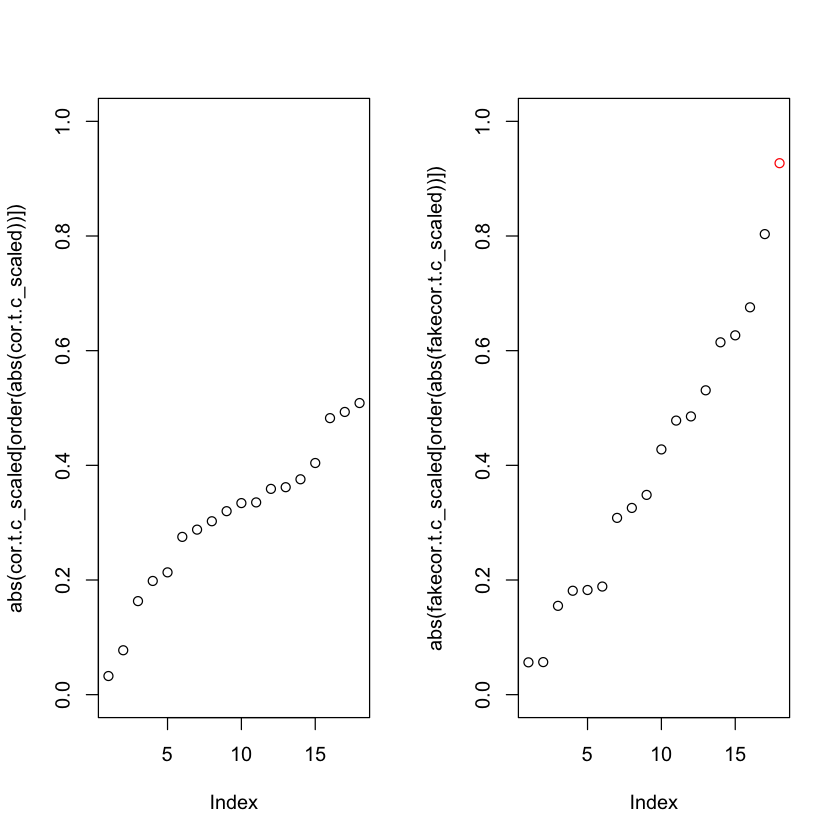

In [110]:
fake.c_scaled = apply(matrix(rnorm(n*p),ncol=p),2,scale,center=TRUE,scale=TRUE)
fake.c_scaled[,1] = scale(t+rnorm(n,0,.15),center=TRUE,scale=TRUE)
fakecor.t.c_scaled = apply(fake.c_scaled,2,function(x,y){cor(x,y)},y=t)
par(mfrow=c(1,2))
plot(abs(cor.t.c_scaled[order(abs(cor.t.c_scaled))]),ylim=c(0,1))
plot(abs(fakecor.t.c_scaled[order(abs(fakecor.t.c_scaled))]),
     ylim=c(0,1),col=rep(2:1,c(1,p-1))[order(abs(fakecor.t.c_scaled))])

In [111]:
fake.c_scaled = fake.c_scaled[,order(abs(fakecor.t.c_scaled),decreasing=TRUE)]

In [ ]:
# COMMENT:
# - not much room for optimism

## LASSO regression scaled features: ConsensusTME REAL DATA

### Automatic selection of lambda


In [112]:
cv.fit_c_scaled <- cv.glmnet(c_scaled, t, family="gaussian", maxit = 1e+5, grouped=FALSE)

### Fit (assuming alpha=1)

In [113]:
fit_c_scaled <- glmnet(c_scaled, t, family =  "gaussian", maxit = 1e+5, standardize=FALSE)

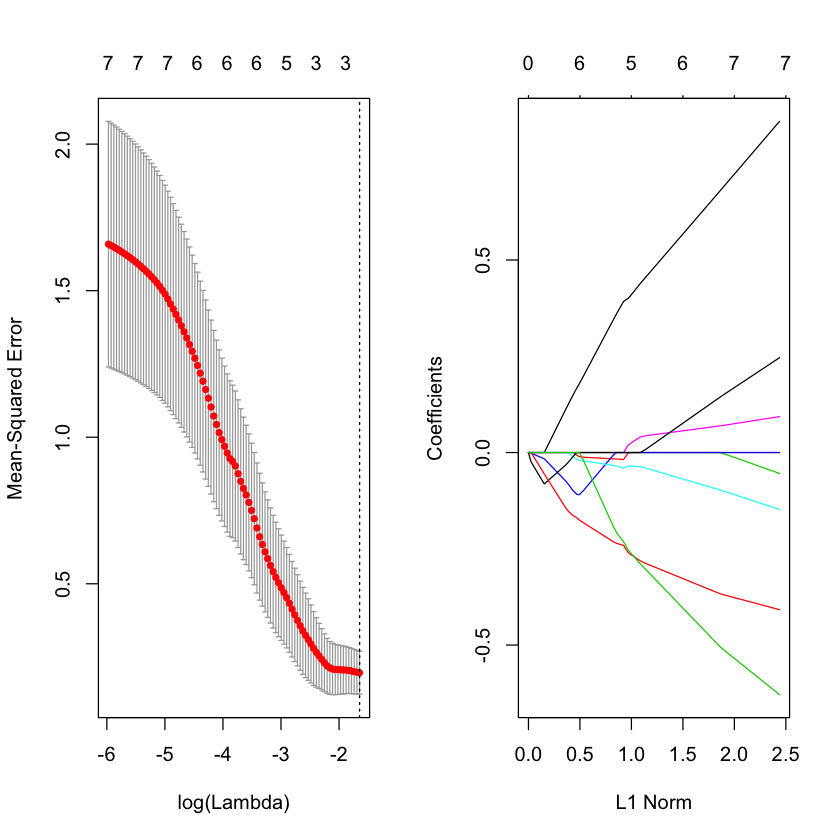

In [114]:
par(mfrow=c(1,2))
plot(cv.fit_c_scaled)
plot(fit_c_scaled)

### Results

In [115]:
Coefficients <- coef(fit_c_scaled, s = cv.fit_c_scaled$lambda.min)
Active.Index <- which(Coefficients != 0)
Active.Coefficients  <- Coefficients[Active.Index]

Active.Index
Active.Coefficients


[1] 1

[1] 0.4689456

In [116]:
cv.fit_c_scaled2 <- cv.glmnet(
    c_scaled,
    t,
    family="gaussian",
    maxit = 1e+5,
    grouped=FALSE,
    standardize=FALSE,
    alpha=1)

coef(cv.fit_c_scaled2, s = "lambda.min")

19 x 1 sparse Matrix of class "dgCMatrix"
                            1
(Intercept)         0.4689456
B_cells             .        
Cytotoxic_cells     .        
Dendritic_cells     .        
Endothelial         .        
Eosinophils         .        
Fibroblasts         .        
Macrophages         .        
Macrophages_M1      .        
Macrophages_M2      .        
Mast_cells          .        
Monocytes           .        
NK_cells            .        
Neutrophils         .        
Plasma_cells        .        
T_cells_CD4         .        
T_cells_CD8         .        
T_cells_gamma_delta .        
T_regulatory_cells  .        

In [ ]:
# COMMENT:
# - only intercept remaining: n=8, p=18...

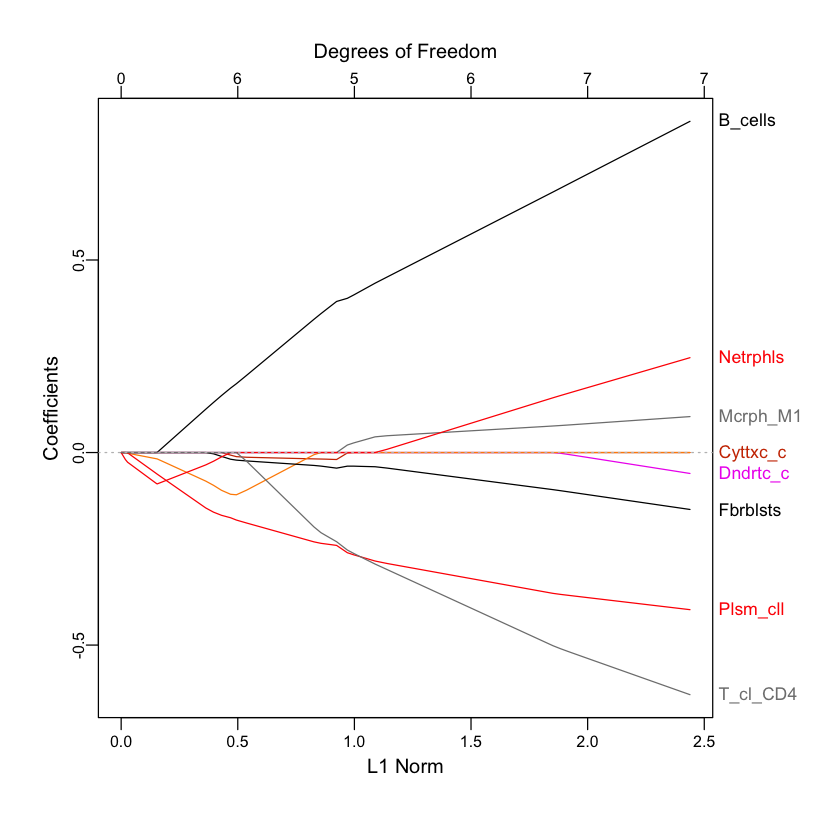

In [117]:
#pdf("../2.Plots/6_f_LASSO_HallmarksConsensus.pdf",width=6,height=4,paper='special') 
plot_glmnet(fit_c_scaled, label=8, xvar="norm")          # label the largets final coefs
#dev.off()


### Above analsysis without scaling


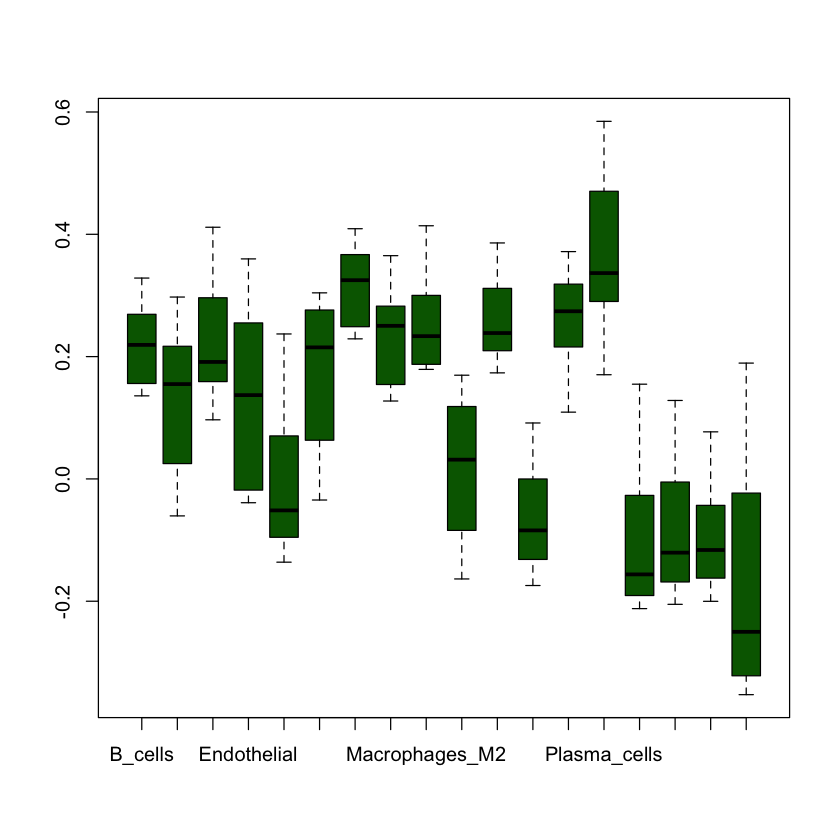

In [118]:
boxplot(c, col=c("darkgreen"))

In [119]:
# cor bw hc and t
cor.t.c = apply(c,2,function(x,y){cor(x,y)},y=t)

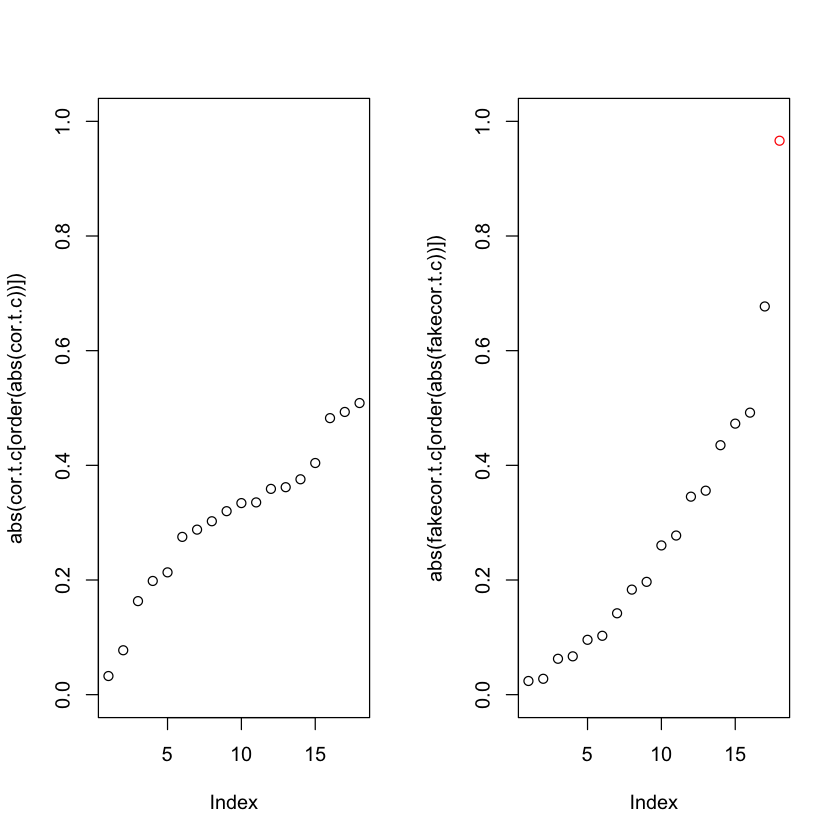

In [120]:
fake.c = apply(matrix(rnorm(n*p),ncol=p),2,scale,center=TRUE,scale=TRUE)
fake.c[,1] = scale(t+rnorm(n,0,.15),center=TRUE,scale=TRUE)
fakecor.t.c = apply(fake.c,2,function(x,y){cor(x,y)},y=t)
par(mfrow=c(1,2))
plot(abs(cor.t.c[order(abs(cor.t.c))]),ylim=c(0,1))
plot(abs(fakecor.t.c[order(abs(fakecor.t.c))]),
     ylim=c(0,1),col=rep(2:1,c(1,p-1))[order(abs(fakecor.t.c))])

In [121]:
fake.c = fake.c[,order(abs(fakecor.t.c),decreasing=TRUE)]

In [122]:
# COMMENT:
# - not much room for optimism

## LASSO regression unscaled features: ConsensusTME REAL DATA

### Automatic selection of lambda

In [123]:
cv.fit_c <- cv.glmnet(c, t, family="gaussian", maxit = 1e+5, grouped=FALSE)

### Fit (assuming alpha=1)

In [124]:
fit_c <- glmnet(c, t, family =  "gaussian", maxit = 1e+5, standardize=FALSE)

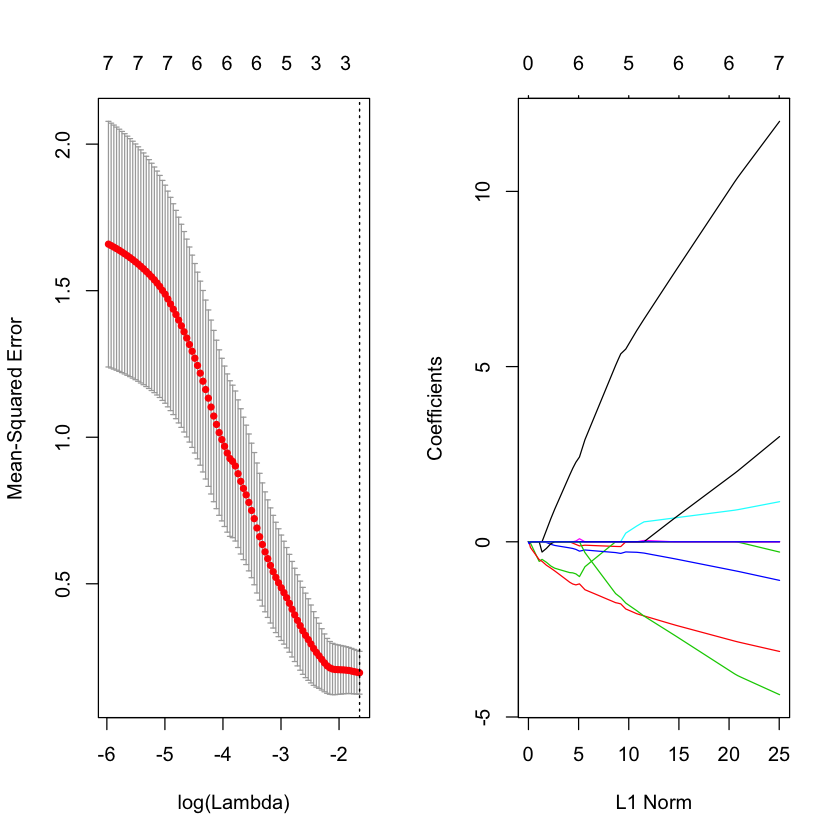

In [125]:
par(mfrow=c(1,2))
plot(cv.fit_c)
plot(fit_c)

### Results

In [126]:
Coefficients <- coef(fit_c, s = cv.fit_c$lambda.min)
Active.Index <- which(Coefficients != 0)
Active.Coefficients  <- Coefficients[Active.Index]

Active.Index
Active.Coefficients

[1] 1

[1] 0.4689456

In [127]:
cv.fit_c2 <- cv.glmnet(
    c,
    t,
    family="gaussian",
    maxit = 1e+5,
    grouped=FALSE,
    standardize=FALSE,
    alpha=1)

coef(cv.fit_c2, s = "lambda.min")

19 x 1 sparse Matrix of class "dgCMatrix"
                            1
(Intercept)         0.4689456
B_cells             .        
Cytotoxic_cells     .        
Dendritic_cells     .        
Endothelial         .        
Eosinophils         .        
Fibroblasts         .        
Macrophages         .        
Macrophages_M1      .        
Macrophages_M2      .        
Mast_cells          .        
Monocytes           .        
NK_cells            .        
Neutrophils         .        
Plasma_cells        .        
T_cells_CD4         .        
T_cells_CD8         .        
T_cells_gamma_delta .        
T_regulatory_cells  .        

In [128]:
# COMMENT:
# - only intercept remaining: n=8, p=18..

In [129]:
# CONCLUSION_AJS:
# - same conclusion with or without scaling

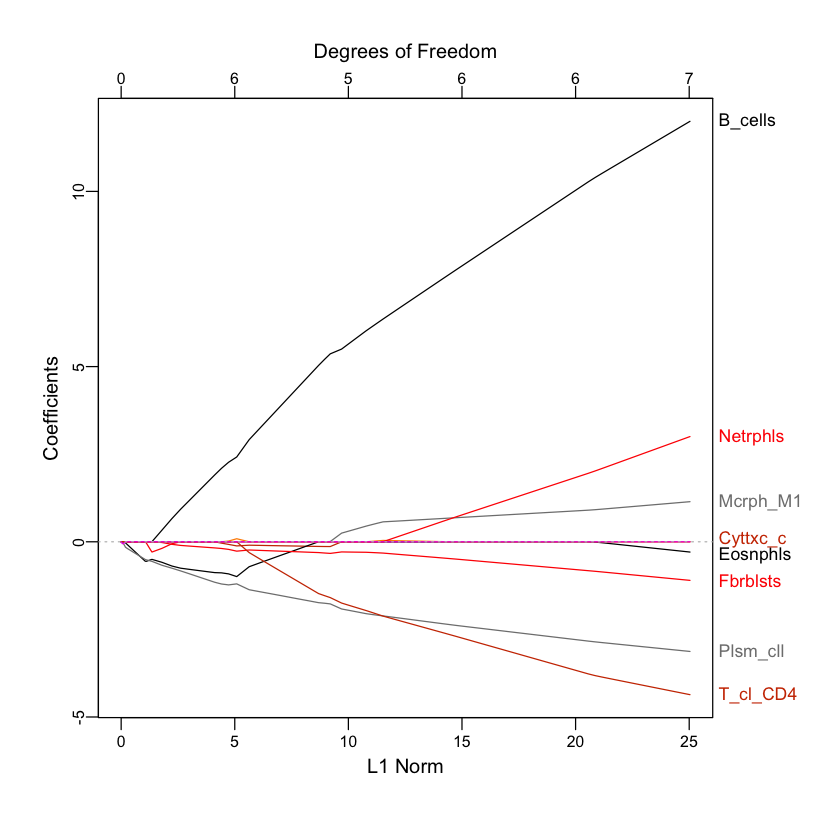

In [130]:
#pdf("../2.Plots/6_f_LASSO_HallmarksConsensus.pdf",width=6,height=4,paper='special') 
plot_glmnet(fit_c, label=8, xvar="norm")          # label the largets final coefs
#dev.off()

## Post-selection inference

In [131]:
library("selectiveInference")

Loading required package: intervals

Attaching package: ‘intervals’

The following object is masked from ‘package:Matrix’:

    expand

Loading required package: survival


In [132]:
lambda = cv.fit_h2$lambda.min
beta_hat = as.numeric(coef(fit_h, s=lambda, exact=TRUE,x=h,y=t))

In [133]:
out = fixedLassoInf(h,t,beta_hat[-1],lambda,family="gaussian")
out

Warning message in fixedLassoInf(h, t, beta_hat[-1], lambda, family = "gaussian"):
“Solution beta does not satisfy the KKT conditions (to within specified tolerances)”Warning message in fixedLassoInf(h, t, beta_hat[-1], lambda, family = "gaussian"):
“p > n/2, and sd(y) = 0.405 used as an estimate of sigma; you may want to use the estimateSigma function”


Call:
fixedLassoInf(x = h, y = t, beta = beta_hat[-1], lambda = lambda, 
    family = "gaussian")

Standard deviation of noise (specified or estimated) sigma = 0.405

Testing results at lambda = 0.012, with alpha = 0.100

 Var  Coef Z-score P-value LowConfPt UpConfPt LowTailArea UpTailArea
  52 -1.54  -1.169   0.262    -3.669    2.433        0.05      0.049

Note: coefficients shown are partial regression coefficients

In [ ]:
# COMMENT:
# - 2 easily selected
# -> low power due to sample size

In [ ]:
## COMMENT on rest of code of AJS:
## - small sample, "some signal", not powered... 
## - model selection not included in inference: BIG ILLUSION !

## Correlation of "potentially important" variables

<p>
https://stats.stackexchange.com/questions/68431/interpretting-lasso-variable-trace-plots
</p>
<p style='text-align: justify;'>
The L1 norm is the regularization term for LASSO. Perhaps a better way to look at it is that the x-axis is the maximum permissible value the L1 norm can take. So when you have a small L1 norm, you have a lot of regularization. Therefore, an L1 norm of zero gives an empty model, and as you increase the L1 norm, variables will "enter" the model as their coefficients take non-zero values.
</p>

<p style='text-align: justify;'>
If you're trying to determine your strongest predictors, you could interpret the plot as evidence that variables that enter the model early (left) are the most predictive and variables that enter the model later are less important... Variables with zeroed-coeffiecients are not useful.
</p>

In [186]:
shapiro.test(consensus_nes[,"Cytotoxic_cells"])


	Shapiro-Wilk normality test

data:  consensus_nes[, "Cytotoxic_cells"]
W = 0.96089, p-value = 0.8186


In [150]:
shapiro.test(hallmark_nes[,"TCR_post_pre"])


	Shapiro-Wilk normality test

data:  hallmark_nes[, "TCR_post_pre"]
W = 0.9573, p-value = 0.784


In [187]:
df <- subset(consensus_nes, select = c(Cytotoxic_cells, TCR_post_pre))

In [188]:
head(stack(df))

values      ind            
1 0.160123909 Cytotoxic_cells
2 0.250782530 Cytotoxic_cells
3 0.149996721 Cytotoxic_cells
4 0.183015171 Cytotoxic_cells
5 0.008473049 Cytotoxic_cells
6 0.041651386 Cytotoxic_cells

In [189]:
bartlett.test(values ~ ind, data = stack(df))


	Bartlett test of homogeneity of variances

data:  values by ind
Bartlett's K-squared = 7.6847, df = 1, p-value = 0.005569


In [164]:
cor.test(hc[,"WNT_BETA_CATENIN_SIGNALING"], t, method="kendall")


	Kendall's rank correlation tau

data:  hc[, "WNT_BETA_CATENIN_SIGNALING"] and t
T = 17, p-value = 0.5484
alternative hypothesis: true tau is not equal to 0
sample estimates:
      tau 
0.2142857 


In [169]:
cor.test(hc_scaled[,"MYC_TARGETS_V2"], t, method="kendall")


	Kendall's rank correlation tau

data:  hc_scaled[, "MYC_TARGETS_V2"] and t
T = 15, p-value = 0.9049
alternative hypothesis: true tau is not equal to 0
sample estimates:
       tau 
0.07142857 


In [170]:
cor.test(hc_scaled[,"G2M_CHECKPOINT"], t, method="kendall")


	Kendall's rank correlation tau

data:  hc_scaled[, "G2M_CHECKPOINT"] and t
T = 19, p-value = 0.2751
alternative hypothesis: true tau is not equal to 0
sample estimates:
      tau 
0.3571429 


In [ ]:
#pdf("../2.Plots/6s_a_g2m_tcr.pdf",width=6,height=4,paper='special') 
plot(hc_scaled[,"G2M_CHECKPOINT"],t)
abline(lm(t~hc_scaled[,"G2M_CHECKPOINT"]))
#dev.off()

In [179]:
cor.test(hc_scaled[,"APOPTOSIS"], t, method="kendall")


	Kendall's rank correlation tau

data:  hc_scaled[, "APOPTOSIS"] and t
T = 6, p-value = 0.06101
alternative hypothesis: true tau is not equal to 0
sample estimates:
       tau 
-0.5714286 


In [ ]:
cor.test(hc_scaled[,"PI3K_AKT_MTOR_SIGNALING"], t, method="spearman")

In [ ]:
cor.test(hc_scaled[,"PANCREAS_BETA_CELLS"], t, method="spearman")

In [ ]:
cor.test(hc_scaled[,"UV_RESPONSE_UP"], t, method="spearman")

In [ ]:
#pdf("../2.Plots/6s_apoptosis_tcr.pdf",width=6,height=4,paper='special') 
plot(hc_scaled[,"APOPTOSIS"],t)
abline(lm(t~hc_scaled[,"APOPTOSIS"]))
#dev.off()

In [ ]:
cor.test(hc_scaled[,"TGF_BETA_SIGNALING"], t, method="spearman")

In [ ]:
cor.test(hc_scaled[,"INTERFERON_ALPHA_RESPONSE"], t, method="spearman")

In [ ]:
cor.test(hc_scaled[,"G2M_CHECKPOINT"], t, method="spearman")

In [184]:
cor.test(hc[,"ImmuneSignature"], t, method="kendall")


	Kendall's rank correlation tau

data:  hc[, "ImmuneSignature"] and t
T = 10, p-value = 0.3988
alternative hypothesis: true tau is not equal to 0
sample estimates:
       tau 
-0.2857143 


In [ ]:
#pdf("../2.Plots/6s_ImmuneSignature_tcr.pdf",width=6,height=4,paper='special') 
plot(hc_scaled[,"ImmuneSignature"],t)
abline(lm(t~hc_scaled[,"ImmuneSignature"]))
#dev.off()

In [ ]:
cor.test(hc_scaled[,"SPERMATOGENESIS"], t, method="spearman")

In [ ]:
cor.test(hc_scaled[,"PEROXISOME"], t, method="spearman")

In [185]:
cor.test(hc_scaled[,"MYC_TARGETS_V2"], t, method="kendall")


	Kendall's rank correlation tau

data:  hc_scaled[, "MYC_TARGETS_V2"] and t
T = 15, p-value = 0.9049
alternative hypothesis: true tau is not equal to 0
sample estimates:
       tau 
0.07142857 


In [ ]:
cor.test(hc_scaled[,"Neutrophils"], t, method="spearman")

In [ ]:
cor.test(hc_scaled[,"B_cells"], t, method="spearman")

In [193]:
cor.test(hc_scaled[,"T_cells_CD4"], t, method="kendall")


	Kendall's rank correlation tau

data:  hc_scaled[, "T_cells_CD4"] and t
T = 11, p-value = 0.5484
alternative hypothesis: true tau is not equal to 0
sample estimates:
       tau 
-0.2142857 


In [190]:
cor.test(hc_scaled[,"Cytotoxic_cells"], t, method="kendall")


	Kendall's rank correlation tau

data:  hc_scaled[, "Cytotoxic_cells"] and t
T = 11, p-value = 0.5484
alternative hypothesis: true tau is not equal to 0
sample estimates:
       tau 
-0.2142857 


In [ ]:
#pdf("../2.Plots/6s_a_Cytotoxic_cells_tcr.pdf",width=6,height=4,paper='special') 
plot(hc_scaled[,"Cytotoxic_cells"],t)
abline(lm(t~hc_scaled[,"Cytotoxic_cells"]))
#dev.off()

In [191]:
cor.test(hc_scaled[,"NK_cells"], t, method="kendall")


	Kendall's rank correlation tau

data:  hc_scaled[, "NK_cells"] and t
T = 12, p-value = 0.7195
alternative hypothesis: true tau is not equal to 0
sample estimates:
       tau 
-0.1428571 


In [192]:
cor.test(hc_scaled[,"T_cells_CD8"], t, method="kendall")


	Kendall's rank correlation tau

data:  hc_scaled[, "T_cells_CD8"] and t
T = 14, p-value = 1
alternative hypothesis: true tau is not equal to 0
sample estimates:
tau 
  0 


# End script